## Unix Preprocessing ##

#check the dimensions of dataset
- bzcat master-telemetry-distilled.bz2 | wc -l   # counts rows >>> 718960374"

- bzcat master-telemetry-distilled.bz2 | head -n 1 | awk -F'\t' '{print NF}'  # counts columns >>> 4

#sorted by timestamp & user_id
- bzcat master-telemetry-distilled.bz2 | sort -t$'\t' -k1,1 -k2,2 > master-telemetry-distilled-cleaned-v1.bz2

#find out how many columns are there
- bzcat master-telemetry-distilled-v1.bz2 | awk '{if(NF>max) max=NF} END{print max}' >>> 19

#split column 4 into 2
- bzcat master-telemetry-distilled-v1.bz2 | awk -F'\t' -v OFS='\t' '{
    if ($4 ~ /^(Command|Param)/) {
        split($4, arr, " ")
        $5 = arr[2] 
        $4 = arr[1]
    }
    print
    }' | bzip2 > master-telemetry-distilled-v2.bz2

#keep only the first 5 columns
- bzcat master-telemetry-distilled-v2.bz2 | cut -f1-5 | bzip2 > master-telemetry-distilled-v3.bz2

#check again the number of rows
- bzcat master-telemetry-distilled-v3.bz2 | wc -l >>> 718960374

#remove rows where user_id is negative
- bzcat master-telemetry-distilled-v3.bz2 | awk -F'\t' 'NF>=2 && $2 >= 0' OFS='\t' | bzip2 > master-telemetry-distilled-v4.bz2

#set column names
- echo -e "timestamp\tuser_id\tversion\tevent\tcommand_type" > header.txt
- cat header.txt <(bzcat master-telemetry-distilled-v4.bz2) | bzip2 > master-telemetry-distilled-v5.bz2

## Data Import ##

In [5]:
#pip install --upgrade numpy pandas

In [6]:
#pip show scikit-learn imbalanced-learn

In [7]:
#pip install imbalanced-learn==0.11.0

In [8]:
#from imblearn.over_sampling import SMOTE

In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from imblearn.over_sampling import SMOTE

**read subset of file**

In [3]:
#read 7M rows

df = pd.read_csv(
    r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\master-telemetry-distilled-v5.bz2",
    sep="\t",                        # tab-separated
    #header=None,                     # no header in file
    #names=["timestamp", "user_id", "version", "event", "command_type"],
    nrows=7_000_000,
    compression="bz2",               # it's compressed with bzip2
    engine="python",                 # handles mixed row lengths safely
)

In [31]:
df.head(100)

,timestamp,user_id,version,event,command_type
0,1293522566,1,5.0.0.46,Crash,None
1,1297251895,1,5.0.0.46,Crash,None
2,1303974836,1,5.0.0.46,Crash,None
3,1315475619,1,5.0.0.46,Crash,None
4,1334732649,1,5.1.0.2,Crash,None
...,...,...,...,...,...
95,1432216439,1,7.0.0.16,Command,vm_freenode_next_name_add
96,1432216443,1,7.0.0.16,Command,vm_pillar_add_corner_next
97,1432216456,1,7.0.0.16,Param,cb_bp_fespa_general_material_type
98,1432216464,1,7.0.0.16,Command,vm_pillar_add_corner_next


In [17]:
#dimensions of table
df.shape

(7000000, 5)

In [18]:
# Quick overview of types and missing values
df.dtypes

timestamp       object
user_id         object
version         object
event           object
command_type    object
dtype: object

## Variable Analysis ##

**timestamp**

**user_id**

In [6]:
df['user_id'].unique()

array([ 1,  7,  9, 11, 14, 15, 20, 27, 31, 33, 35, 38, 44, 47, 48, 52, 59],
      dtype=int64)

In [7]:
# number of unique users
df["user_id"].nunique()

17

In [8]:
# count per user_id (most active users)
df["user_id"].value_counts().head(20)

user_id
15    2303402
59    1062538
1      767608
20     626480
47     488977
52     417851
33     259576
11     214604
35     197672
9      179090
7      170959
38      99224
44      80117
14      45161
31      44854
27      41882
48          5
Name: count, dtype: int64

**version**

In [9]:
df['version'].unique()

array(['5.0.0.46', '5.1.0.2', '5.4.0.14', '5.4.0.100', '5.6.0.14',
       '7.0.0.16', '7.1.0.2', '7.1.0.64', '7.2.0.50', '7.4.0.4',
       '7.6.0.4', '7.1.0.66', '8.0.0.8', '8.1.0.22', '8.2.0.72',
       '8.3.0.16', '9.1.0.16', '9.1.0.46', '7.6.0.24', '5.6.0.6',
       '7.5.0.20', '8.1.0.2', '8.1.0.4', '8.1.0.18', '7.7.0.100',
       '5.0.0.34'], dtype=object)

In [10]:
# number of unique users
df["version"].nunique()

26

In [11]:
# count per user_id
df["version"].value_counts().head(20)

version
8.1.0.22     2736988
7.6.0.24      658988
7.1.0.64      658782
7.6.0.4       548168
8.3.0.16      467698
7.2.0.50      352485
8.1.0.4       325932
8.0.0.8       303172
9.1.0.46      248242
8.2.0.72      199121
7.4.0.4       165731
7.0.0.16       85512
7.1.0.2        75262
7.5.0.20       48737
8.1.0.18       46846
9.1.0.16       44721
7.7.0.100      21532
8.1.0.2        11878
7.1.0.66         114
5.6.0.14          28
Name: count, dtype: int64

**event**

In [12]:
# number of unique users
df["event"].nunique()

5

In [13]:
df['event'].unique()

array(['Crash', 'Start', 'End', 'Command', 'Param'], dtype=object)

In [14]:
# count per user_id
df["event"].value_counts()

event
Command    6376726
Param       539064
End          45509
Start        38347
Crash          354
Name: count, dtype: int64

**command_type**

In [15]:
# number of unique users
df["command_type"].nunique()

2408

**crosstable version-event**

In [16]:
pd.crosstab(df["version"], df["event"])

event,Command,Crash,End,Param,Start
version,,,,,
5.0.0.34,0,2,0,0,0
5.0.0.46,0,20,0,0,0
5.1.0.2,0,23,0,0,0
5.4.0.100,0,1,0,0,0
5.4.0.14,0,11,0,0,0
5.6.0.14,0,28,0,0,0
5.6.0.6,0,6,0,0,0
7.0.0.16,78019,9,890,5759,835
7.1.0.2,70443,0,498,3842,479


**commands counts per version**

In [17]:
# keep non-null rows
commands_df = df[df["command_type"].notna()]

# count of commands per version
commands_df.groupby("version")["command_type"].value_counts()

version   command_type                  
7.0.0.16  vm_change_sel_add_win             6913
          vm_change_sel_new                 3908
          vm_line_add2p                     3665
          vm_change_move                    3434
          vm_hatch_def_start                3163
                                            ... 
9.1.0.46  vm_text_change_begin_depend_pt       1
          vm_text_change_end_depend_pt         1
          vm_text_set_all_selected             1
          vm_text_set_top_right_allign         1
          vm_wall_send_back                    1
Name: count, Length: 16476, dtype: int64

**number of commands per version**

In [18]:
# Keep only rows where command_type is not null
commands_df = df[df["command_type"].notna()]

# Count unique commands per version
commands_df.groupby("version")["command_type"].nunique()

version
7.0.0.16      714
7.1.0.2       640
7.1.0.64     1038
7.1.0.66       50
7.2.0.50     1056
7.4.0.4      1081
7.5.0.20      429
7.6.0.24     1401
7.6.0.4      1280
7.7.0.100     282
8.0.0.8       999
8.1.0.18      327
8.1.0.2       270
8.1.0.22     1745
8.1.0.4       883
8.2.0.72     1115
8.3.0.16     1291
9.1.0.16      695
9.1.0.46     1180
Name: command_type, dtype: int64

In [19]:
# keep non-na command_type
commands_df = df[df["command_type"].notna()]

# unique commands per version
unique_commands_per_version = commands_df.groupby("version")["command_type"].nunique()

# unique users per version
unique_users_per_version = commands_df.groupby("version")["user_id"].nunique()

summary = pd.DataFrame({
    "unique_command_count": unique_commands_per_version,
    "unique_user_count": unique_users_per_version
}).reset_index()

summary.sort_values(by="unique_command_count", ascending=False)

,version,unique_command_count,unique_user_count
13,8.1.0.22,1745,12
7,7.6.0.24,1401,8
16,8.3.0.16,1291,8
8,7.6.0.4,1280,5
18,9.1.0.46,1180,7
15,8.2.0.72,1115,6
5,7.4.0.4,1081,4
4,7.2.0.50,1056,10
2,7.1.0.64,1038,7
10,8.0.0.8,999,5


**number of upgrades per version**

In [ ]:
df["version"] = df["version"].astype(str)
df = df.sort_values(["user_id", "timestamp"])
df["next_version"] = df.groupby("user_id")["version"].shift(-1)

upgrade_counts = df6[df6["version"] != df6["next_version"]] \
                    .groupby(["version", "next_version"]) \
                    .size() \
                    .reset_index(name="count") \
                    .sort_values("count", ascending=False)

upgrade_counts.head(20)


## Data Preprocessing and Cleaning Steps ##

**1) Handle Missing Values**

In [3]:
#check for missing values
df.isnull().sum()

timestamp           0
user_id             0
version             0
event               0
command_type    84211
dtype: int64

In [4]:
# Count rows where all columns are blank
num_blank_rows = df.isna().all(axis=1).sum()

print(f"Number of completely blank rows: {num_blank_rows}")

Number of completely blank rows: 0


In [5]:
# Remove rows where user_id is missing
df1 = df[df["user_id"].notna()]

# Optional: reset index after dropping rows
df1 = df1.reset_index(drop=True)

In [6]:
#verify there are no missing values
df1.isnull().sum()

timestamp           0
user_id             0
version             0
event               0
command_type    84211
dtype: int64

**2) Handle duplicate rows**

In [7]:
#count duplicate rows
df1.duplicated().sum()

261897

In [8]:
#drop duplicate rows
df2 = df1.drop_duplicates().copy()

#reset index
df2 = df2.reset_index(drop=True)

In [9]:
df2.duplicated().sum()

0

**3) Filtering Dataset by Relevant Software Versions**

In [38]:
print(df2.head())

    timestamp  user_id   version  event command_type
0  1293522566        1  5.0.0.46  Crash         None
1  1297251895        1  5.0.0.46  Crash         None
2  1303974836        1  5.0.0.46  Crash         None
3  1315475619        1  5.0.0.46  Crash         None
4  1334732649        1   5.1.0.2  Crash         None


In [10]:
df3 = df2.copy()

# Read valid versions and their release dates from the txt file
valid_versions = pd.read_csv(
    'C:/Users/katsi/OneDrive/Business_Analytics/Thesis/Data/Fespa & Tekton Versions.txt', 
    sep='\s+',       # splits on whitespace
    header=None,     # no header in txt
    names=['version', 'release_date']
)

# keep only valid versions and add release_date
df3 = df3.merge(valid_versions, on='version', how='inner')

# Reset index correctly
df3.reset_index(drop=True, inplace=True)

In [11]:
unique_versions = df3['version'].unique()

print(unique_versions)

['5.0.0.46' '5.1.0.2' '5.4.0.14' '5.4.0.100' '5.6.0.14' '7.0.0.16'
 '7.1.0.2' '7.1.0.64' '7.2.0.50' '7.4.0.4' '7.6.0.4' '8.0.0.8' '8.1.0.22'
 '8.2.0.72' '8.3.0.16' '9.1.0.16' '9.1.0.46' '7.6.0.24' '5.6.0.6'
 '7.5.0.20' '8.1.0.2' '8.1.0.4' '8.1.0.18' '7.7.0.100' '5.0.0.34']


In [12]:
df3['release_date'].unique()

array(['9/7/2010', '5/8/2011', '6/2/2013', '28/5/2013', '13/12/2013',
       '23/6/2015', '19/4/2016', '27/7/2016', '25/5/2017', '20/4/2018',
       '3/8/2018', '24/4/2020', '20/1/2021', '17/6/2022', '20/12/2022',
       '12/12/2023', '16/2/2024', '13/11/2018', '9/10/2013', '11/7/2018',
       '20/7/2020', '5/8/2020', '18/12/2020', '5/3/2020', '3/5/2010'],
      dtype=object)

**4) Create column with datetime format**

In [13]:
df4 = df3.copy()

df4 = df4[df4['timestamp'] != 'timestamp']

# Create datetime
datetime_col = pd.to_datetime(df4['timestamp'], unit='s')

# Find the index position of 'timestamp'
pos = df4.columns.get_loc('timestamp') + 1

# Insert datetime, year, and month right after timestamp
df4.insert(pos, 'datetime', datetime_col)
df4.insert(pos + 1, 'year', datetime_col.dt.year)
df4.insert(pos + 2, 'month', datetime_col.dt.month)

**5) Remove row where year is equal to '2036'**

In [14]:
# Remove row where year is equal to '2036'
df5 = df4[df4['year'] != 2036].reset_index(drop=True)

**6) Transform version column from object to category**

In [15]:
df5['version'] = df5['version'].astype('category')

**7) Transform event column from object to category**

In [16]:
df5['event'] = df5['event'].astype('category')

**8) Transform release_date column into datetime**

In [17]:
df5['release_date'] = pd.to_datetime(
    df5['release_date'], dayfirst=True, errors='coerce'
)

In [18]:
# Keep only the date part (drop time)
df5['release_date'] = df5['release_date'].dt.date

In [19]:
df5.shape

(6737990, 9)

In [20]:
df5.dtypes

timestamp                int64
datetime        datetime64[ns]
year                     int32
month                    int32
user_id                  int64
version               category
event                 category
command_type            object
release_date            object
dtype: object

**9) Compute Upgrade Variable**

In [23]:
df5.dtypes

timestamp                int64
datetime        datetime64[ns]
year                     int32
month                    int32
user_id                  int64
version               category
event                 category
command_type            object
release_date            object
dtype: object

In [24]:
#### THE FIRST START PER VERSION ####

#import pandas as pd
#import numpy as np

# Make a working copy
df6 = df5.copy()

# Ensure version is string (for parsing)
df6['version'] = df6['version'].astype(str)

# Convert version strings "1.2.3" into comparable numeric tuples
def version_to_tuple(v):
    return tuple(map(int, v.split('.')))
df6['version_tuple'] = df6['version'].apply(version_to_tuple)

# Sort by user + time
df6 = df6.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# Initialize upgrade column
df6['upgrade'] = 0


def mark_upgrade_per_version(group):
    """
    For each user:
    - Track all Start events
    - For each version, mark ONLY the first Start as 1 if the user later starts a higher version
    - All other events get 0
    """

    # Keep only Start events
    starts = group[group['event'] == 'Start'].copy()
    if starts.empty:
        return pd.Series(0, index=group.index)

    # Determine the highest version this user ever started
    max_version = starts['version_tuple'].max()

    # A user upgrades from version X if max_version > X
    starts['will_upgrade'] = (starts['version_tuple'] < max_version).astype(int)

    # For each version, only mark THE FIRST Start event
    first_starts = (
        starts.sort_values('timestamp')
              .groupby('version_tuple')
              .head(1)
              .copy()
    )

    # Assign upgrade = will_upgrade for those first start rows
    upgrade_flags = pd.Series(0, index=group.index)
    upgrade_flags.loc[first_starts.index] = first_starts['will_upgrade'].astype(int)

    return upgrade_flags


# Apply per user
df6['upgrade'] = df6.groupby('user_id').apply(mark_upgrade_per_version).reset_index(level=0, drop=True)

# Clean up temporary column
df6.drop(columns='version_tuple', inplace=True)

C:\Users\katsi\AppData\Local\Temp\ipykernel_10456\3883760363.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df6['upgrade'] = df6.groupby('user_id').apply(mark_upgrade_per_version).reset_index(level=0, drop=True)


**verification steps**

In [25]:
# check that each user–version pair has at most one upgrade
check1 = df6[df6['upgrade'] == 1].groupby(['user_id', 'version']).size()

# Show only those with more than one (should be empty)
check1[check1 > 1]

Series([], dtype: int64)

In [26]:
# check that upgrade appears only on START events
df6[df6['upgrade'] == 1]['event'].value_counts()

event
Start      77
Command     0
Crash       0
End         0
Param       0
Name: count, dtype: int64

In [31]:
df6.to_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df6.csv", index=False)

## Descriptive and Explanatory Data Analysis ##

In [32]:
df6 = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df6.csv")

**year**

In [33]:
# Year frequency table with percentage
year_table = (
    df6['year'].value_counts()
       .sort_values(ascending=False)
       .to_frame('count')
)

# Add percentage column
year_table['percentage'] = (year_table['count'] / len(df6) * 100).round(2)

# Format count with thousands separator and percentage with '%'
year_table['count'] = year_table['count'].apply(lambda x: f"{x:,}")
year_table['percentage'] = year_table['percentage'].map("{:.2f}%".format)

year_table.rename(columns={'count': 'count_of_commands'}, inplace=True)

print("\n-- Year Distribution --\n" + year_table.to_string())


-- Year Distribution --
     count_of_commands percentage
year                             
2021         1,203,474     17.86%
2023         1,030,926     15.30%
2022           988,484     14.67%
2020           832,989     12.36%
2019           779,477     11.57%
2024           674,150     10.01%
2018           547,719      8.13%
2025           359,151      5.33%
2017           142,804      2.12%
2016           128,106      1.90%
2015            50,258      0.75%
2005               372      0.01%
2014                19      0.00%
2007                16      0.00%
2012                15      0.00%
2011                14      0.00%
2013                10      0.00%
2010                 6      0.00%


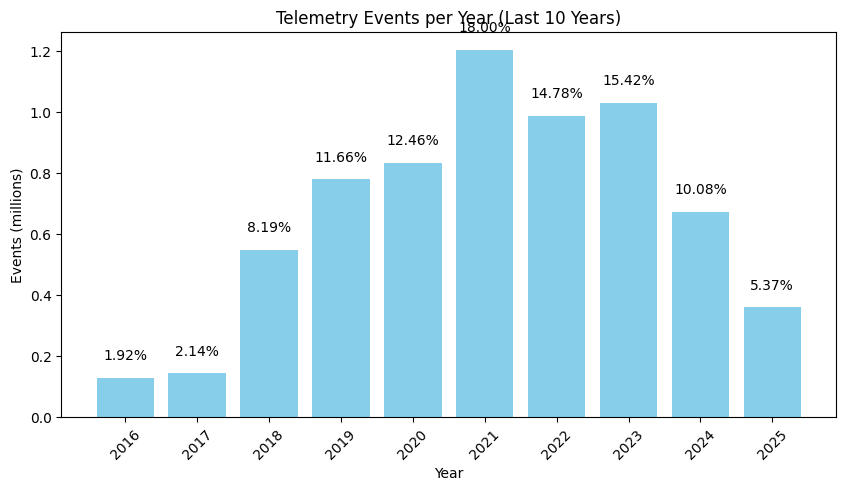

In [34]:
#barplot for the last 10 years

import matplotlib.pyplot as plt

# Last 10 years counts
year_counts = df6[df6['year'] >= 2016]['year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,5))
bars = plt.bar(year_counts.index.astype(str), year_counts.values / 1_000_000, color='skyblue')

plt.xlabel('Year')
plt.ylabel('Events (millions)')
plt.title('Telemetry Events per Year (Last 10 Years)')
plt.xticks(rotation=45)

# Percentages
for bar, count in zip(bars, year_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f"{count / year_counts.sum() * 100:.2f}%", 
             ha='center', va='bottom', fontsize=10)

plt.show()

**version**

In [35]:
# Create frequency table
version_table = (
    df6['version'].value_counts()
       .sort_values(ascending=False)
       .to_frame('count')
)

# Add percentage column
version_table['percentage'] = (version_table['count'] / len(df6) * 100).round(2)

# Sort by count before formatting
version_table = version_table.sort_values(by='count', ascending=False)

# Format nicely
version_table['count'] = version_table['count'].apply(lambda x: f"{x:,}")
version_table['percentage'] = version_table['percentage'].map("{:.2f}%".format)

print(version_table)

               count percentage
version                        
8.1.0.22   2,673,003     39.67%
7.6.0.24     638,098      9.47%
7.1.0.64     592,245      8.79%
7.6.0.4      530,367      7.87%
8.3.0.16     457,859      6.80%
7.2.0.50     343,506      5.10%
8.1.0.4      318,905      4.73%
8.0.0.8      293,322      4.35%
9.1.0.46     227,610      3.38%
8.2.0.72     191,356      2.84%
7.4.0.4      149,908      2.22%
7.0.0.16      83,243      1.24%
7.1.0.2       74,182      1.10%
8.1.0.18      46,171      0.69%
7.5.0.20      44,730      0.66%
9.1.0.16      41,566      0.62%
7.7.0.100     20,041      0.30%
8.1.0.2       11,795      0.18%
5.6.0.14          25      0.00%
5.1.0.2           21      0.00%
5.0.0.46          18      0.00%
5.4.0.14          10      0.00%
5.6.0.6            6      0.00%
5.0.0.34           2      0.00%
5.4.0.100          1      0.00%


**upgrades per version**

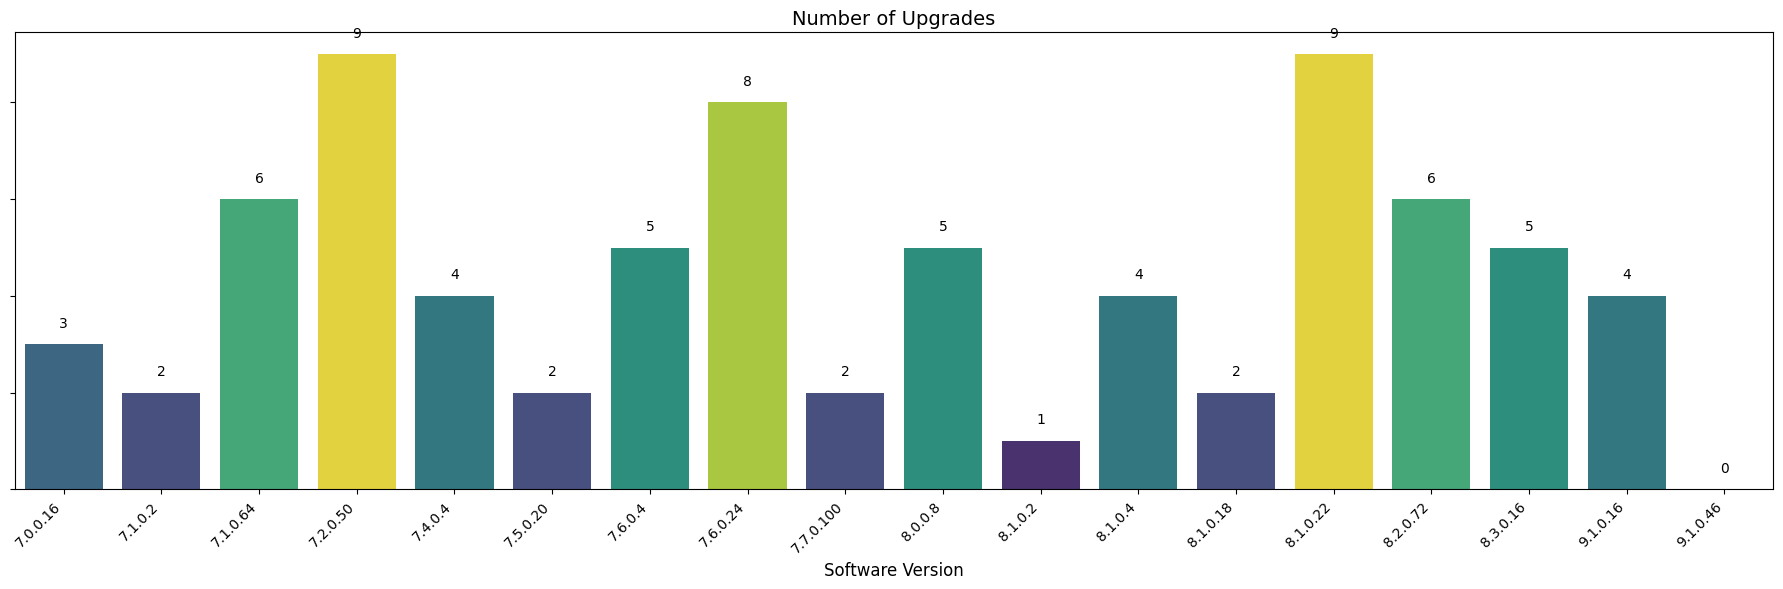

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Count upgrades per version (only Start events)
upgrade_counts = (
    df6[df6['event'] == 'Start']
    .groupby('version')['upgrade']
    .sum()
    .reset_index()
)

# Step 2: Convert version strings to tuples for proper sorting
upgrade_counts['version_tuple'] = upgrade_counts['version'].apply(
    lambda v: tuple(int(x) for x in v.split('.'))
)

# Step 3: Sort by tuple
upgrade_counts = upgrade_counts.sort_values('version_tuple').reset_index(drop=True)

# Step 4: Plot
plt.figure(figsize=(18, 6))  # wider figure

# Color palette: darker = more upgrades
palette = sns.color_palette("viridis", as_cmap=True)
norm_colors = upgrade_counts['upgrade'] / upgrade_counts['upgrade'].max()
bar_colors = [palette(x) for x in norm_colors]

barplot = sns.barplot(
    x='version',
    y='upgrade',
    hue='upgrade',   # assign hue to trigger palette
    data=upgrade_counts,
    palette='viridis',
    dodge=False,     # avoid splitting bars
    legend=False
)

plt.xlabel('Software Version', fontsize=12)
plt.ylabel('')  # hide y-axis label
plt.title('Number of Upgrades', fontsize=14)

# Remove y-axis tick labels
barplot.set_yticklabels([])

# Annotate bars with the actual number on top
for idx, row in enumerate(upgrade_counts.itertuples()):
    barplot.text(
        idx,
        row.upgrade + 0.3,  # slightly above the bar
        f"{row.upgrade}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**percentage of first upgrade per version**

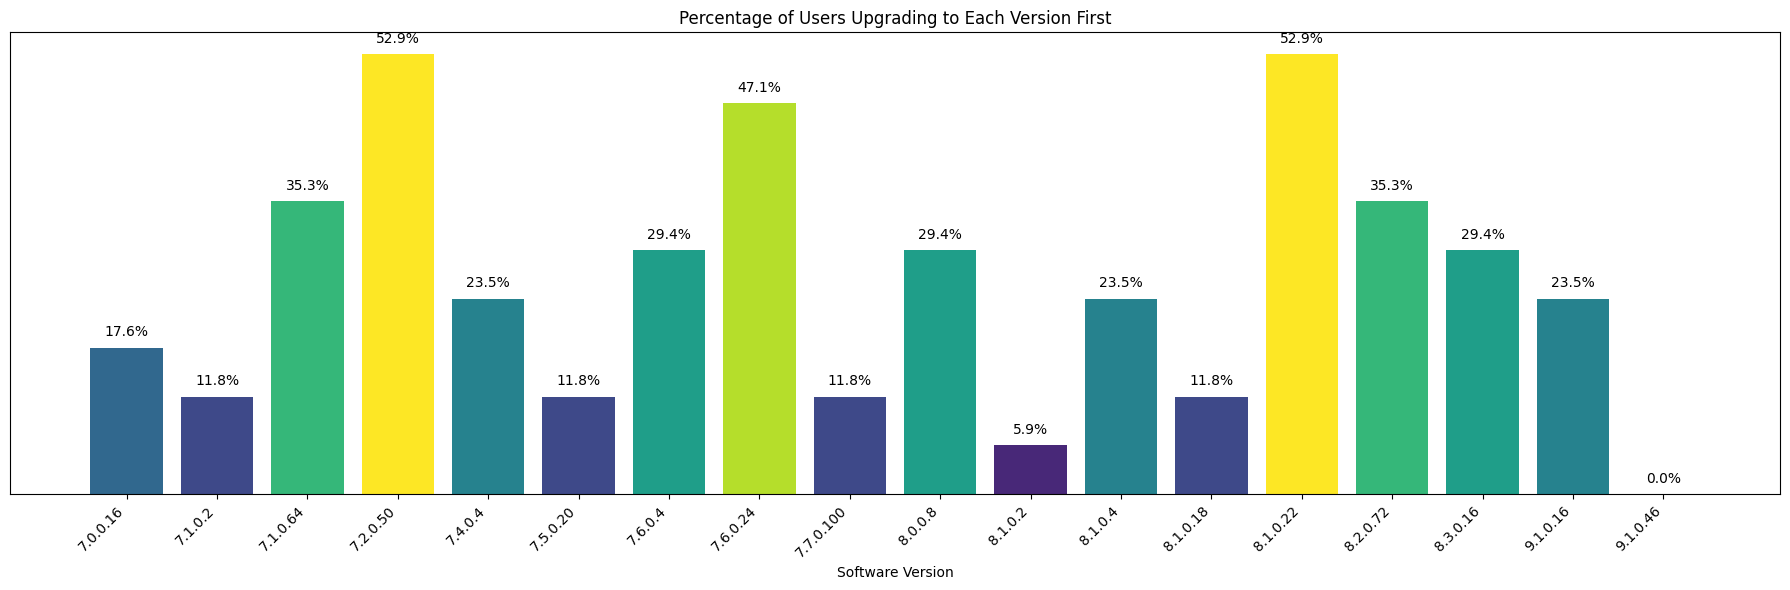

In [44]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Step 1: Count upgrades per version
upgrade_counts = (
    df6[df6['event'] == 'Start']
    .groupby('version')['upgrade']
    .sum()
    .reset_index()
)

# Step 2: Compute total users
total_users = df6['user_id'].nunique()

# Step 3: Convert counts to percentages
upgrade_counts['upgrade_pct'] = (upgrade_counts['upgrade'] / total_users) * 100

# Step 4: Sort versions properly
upgrade_counts['version_tuple'] = upgrade_counts['version'].apply(
    lambda v: tuple(int(x) for x in v.split('.'))
)
upgrade_counts = upgrade_counts.sort_values('version_tuple').reset_index(drop=True)

# Normalize values for coloring
norm = mcolors.Normalize(vmin=upgrade_counts['upgrade_pct'].min(), vmax=upgrade_counts['upgrade_pct'].max())
colors = cm.viridis(norm(upgrade_counts['upgrade_pct']))

plt.figure(figsize=(18,6))
bars = plt.bar(upgrade_counts['version'], upgrade_counts['upgrade_pct'], color=colors)

# Annotate bars
for bar, pct in zip(bars, upgrade_counts['upgrade_pct']):
    plt.text(bar.get_x() + bar.get_width()/2, pct + 1, f"{pct:.1f}%", ha='center', va='bottom')

plt.xlabel('Software Version')
plt.ylabel('')
plt.title('Percentage of Users Upgrading to Each Version First')
plt.yticks([])  # remove y-axis
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**event-based upgrade rate**

What percentage of all events are upgrades?

In [47]:
# Make safe copy
df7 = df6[['user_id', 'datetime', 'version']].copy()

# Sort by user and datetime
df7 = df7.sort_values(['user_id', 'datetime'])

# Keep only first Start of each version per user
first_starts = df7.drop_duplicates(subset=['user_id', 'version'], keep='first').copy()  # <-- copy here

# Compute previous version safely
first_starts.loc[:, 'prev_version'] = first_starts.groupby('user_id')['version'].shift(1)

# Identify upgrades safely
first_starts.loc[:, 'upgrade'] = (first_starts['version'] != first_starts['prev_version']) & first_starts['prev_version'].notna()

# Compute overall upgrade rate
upgrade_rate = first_starts['upgrade'].mean() * 100
print(f"Upgrade rate: {upgrade_rate:.2f}%")

Upgrade rate: 85.09%


After computing the upgrade rate, we found that a certain proportion of users move from one version to a newer version of the software. By considering only the first Start event of each version per user, we ensure that repeated usage of the same version does not inflate the count. The resulting upgrade rate, expressed as a percentage, reflects the likelihood that a user will upgrade from a given version, providing a clear summary of user adoption behavior and forming a baseline for predictive modeling. This metric aligns with the thesis goal of understanding and predicting user upgrade behavior.

The computed upgrade rate shows that 85.09% of users eventually move from one version to a newer version. This high rate indicates that the majority of users adopt new versions after initially starting an earlier one. By considering only the first Start event of each version per user, this measure accurately reflects the likelihood of a user upgrading, without overcounting repeated usage of the same version, and provides a clear benchmark for modeling upgrade behavior.
    

**upgrade rate**

What percentage of users ever upgraded?

In [51]:
# Only keep necessary columns
df8 = df6[['user_id','version']].copy()

# Convert version strings to tuples for proper comparison
df8['version_tuple'] = df8['version'].apply(lambda v: tuple(map(int, v.split('.'))))

# Get first and last version per user
user_versions = df8.groupby('user_id')['version_tuple'].agg(['first','last']).reset_index()

# Mark if upgraded
user_versions['upgraded'] = user_versions['first'] != user_versions['last']

# Compute per-user upgrade rate
upgrade_rate_users = user_versions['upgraded'].mean() * 100
print(f"upgrade rate: {upgrade_rate_users:.2f}%")


upgrade rate: 94.12%


Explanation:

- 94.12% of users upgraded at least once
- This per-user metric is a better indicator of adoption and can guide decisions like: 1) Which versions are most popular, 2) How quickly users adopt new releases
- This metric indicates the proportion of users who ever switched to a newer version after their initial version. Unlike the overall row-based upgrade rate, it provides a user-centric view, showing how common upgrading is across your user base. For example, if upgrade_rate_users = 78.5%, this would mean that 78.5% of users upgraded at least once from their first version to a higher version.

**per-version upgrade rate**

**per-user upgrade rate**

**frequency and distribution of commands used**

In [57]:
#count per event
df11 = df6['event'].value_counts().to_frame('count').reset_index()
df11 = df11.rename(columns={'index': 'event'})

# Convert count to int and format with commas (no decimals)
df11['count'] = df11['count'].astype(int).map('{:,}'.format)

# Compute percentage from the count column and add % symbol
total_events = df6['event'].count()
df11['percentage'] = (df11['count'].str.replace(',', '').astype(int) / total_events * 100).round(2).astype(str) + '%'

# Sort by count descending
df11 = df11.sort_values(by='count', ascending=False).reset_index(drop=True)

print(df11)

     event      count percentage
0  Command  6,140,600     91.13%
1    Param    525,340       7.8%
2      End     37,897      0.56%
3    Crash        345      0.01%
4    Start     33,808       0.5%


## Feature Categories ##

### <u>Usage Features</u> ###

**1) Total number of commands in last 7 days**

How many events (or commands) the user triggered during the last 7 days

In [58]:
df12 = df6.copy(deep=False)

from datetime import timedelta

# Ensure datetime column is actually datetime type
df12['datetime'] = pd.to_datetime(df12['datetime'])
    
# define the 7 days timeframe
end_date = df12['datetime'].max()
start_date_7 = end_date - timedelta(days=7)

# keep events from the last 7 days
recent_7 = df12[(df12['datetime'] >= start_date_7) & (df12['datetime'] <= end_date)]

# count 'Command' or 'Param' events per user
command_param_count_weekly = (
    recent_7[recent_7['event'].isin(['Command', 'Param'])]
    .groupby('user_id')
    .size()
    .rename('command_param_count_weekly')
)

# merge with existing df
df12 = df12.merge(command_param_count_weekly, on='user_id', how='left')

# Fill missing values with 0 and convert to int
df12['command_param_count_weekly'] = df12['command_param_count_weekly'].fillna(0).astype(int)

df12.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929


**2) Active days in last 30 days**

Number of distinct days in the past 30 days when the user was active

In [59]:
# Make a copy of df12
df13 = df12.copy(deep=False)

# 30-day window
start_date_30 = end_date - timedelta(days=30)
recent_30 = df13[(df13['datetime'] >= start_date_30) & (df13['datetime'] <= end_date)]

# Compute number of unique active days per user in last 30 days
days_active_last_30 = (
    recent_30.groupby('user_id')['datetime']
    .apply(lambda x: x.dt.date.nunique())  # count unique dates
    .rename('days_active_last_30')
)

# Merge into df12
df13 = df13.merge(days_active_last_30, on='user_id', how='left')

# Optional: fill users with no activity in last 30 days with 0
df13['days_active_last_30'] = df13['days_active_last_30'].fillna(0).astype(int)

df13.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17


In [60]:
# verify that this variable does not exceed the 30 days
df13['days_active_last_30'].unique()

array([17, 23, 18,  4,  0, 26, 15,  6,  8, 20,  1, 16,  7])

**3) Average sessions per week**

Average number of software sessions per week


In [61]:
# Make a copy of df13
df14 = df13.copy(deep=False)

# Filter only session-related events
sessions = df14[df14['event'].isin(['Start', 'End'])]

# Total number of unique weeks in the dataset
total_weeks = df14['datetime'].dt.isocalendar().week.nunique()

# Compute average sessions per week per user using transform
df14['avg_sessions_per_week'] = (
    sessions.groupby('user_id')['datetime']
    .transform(lambda x: round(x.dt.isocalendar().week.nunique() / total_weeks, 2))
)

# Fill users with no sessions with 0
df14['avg_sessions_per_week'] = df14['avg_sessions_per_week'].fillna(0)

df14.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30,avg_sessions_per_week
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17,0.0


**4) Total usage time (if Start/End events available)**

Total active time spent using the software (difference between “Start” and “End” events)

In [63]:
#import pandas as pd

# Make a copy of df14
df15 = df14.copy()

# Ensure datetime column is proper datetime type
df15['datetime'] = pd.to_datetime(df15['datetime'])

# Filter only start/end events and sort by user and datetime
df_sessions = df15[df15['event'].str.lower().isin(['start', 'end'])].sort_values(['user_id', 'datetime'])

# Calculate total usage time per user
durations = []

for user, group in df_sessions.groupby('user_id'):
    group = group.sort_values('datetime')
    stack = []  # keep unmatched start events
    total_seconds = 0
    for _, row in group.iterrows():
        if row['event'].lower() == 'start':
            stack.append(row['datetime'])
        elif row['event'].lower() == 'end' and stack:
            start_time = stack.pop(0)  # pair with earliest unmatched start
            total_seconds += (row['datetime'] - start_time).total_seconds()
    durations.append({'user_id': int(user), 'total_usage_time_hours': total_seconds / 3600})

# Create total_usage_time DataFrame
total_usage_time = pd.DataFrame(durations)

# Round total usage time to 2 decimals
total_usage_time['total_usage_time_hours'] = total_usage_time['total_usage_time_hours'].round()

if 'total_usage_time_hours' in df15.columns:
    df15 = df15.drop(columns=['total_usage_time_hours'])

df15 = df15.merge(total_usage_time, on='user_id', how='left')

# Fill NaN for users with no usage
df15['total_usage_time_hours'] = df15['total_usage_time_hours'].fillna(0)

# Optional: check first few rows per user
print(df15[['user_id', 'total_usage_time_hours']].drop_duplicates().head(10))

         user_id  total_usage_time_hours
0              1                  7251.0
749391         7                  6300.0
916748         9                  4892.0
1094996       11                 12151.0
1302946       14                  1881.0
1345625       15                 29635.0
3589051       20                  9477.0
4194023       27                  3010.0
4235331       31                   601.0
4279335       33                 25095.0


**5) Mean gap between sessions (hours)**

Average time gap (in hours) between one session and the next

In [64]:
#import pandas as pd

# Make a copy of df15
df16 = df15.copy()

# Ensure datetime is datetime type
df16['datetime'] = pd.to_datetime(df16['datetime'])

# Only keep start/end events for gap calculation
df_sessions = df16[df16['event'].str.lower().isin(['start','end'])]

# List to store results
inter_gaps = []

# Process per user
for user, group in df_sessions.groupby('user_id'):
    group = group.sort_values('datetime')  # sort by time
    prev_end = None
    for _, row in group.iterrows():
        if row['event'].lower() == 'end':
            prev_end = row['datetime']
        elif row['event'].lower() == 'start':
            if prev_end is not None:
                gap_hours = (row['datetime'] - prev_end).total_seconds() / 3600
                inter_gaps.append({
                    'user_id': user,
                    'start_datetime': row['datetime'],
                    'inter_session_gap_hours': gap_hours
                })
            prev_end = None  # reset to avoid double-counting

# Create DataFrame with inter-session gaps
df_inter_gaps = pd.DataFrame(inter_gaps)

# Now merge safely
df16 = df16.merge(
    df_inter_gaps,
    left_on=['user_id', 'datetime'],
    right_on=['user_id', 'start_datetime'],
    how='left'
)

# Clean up
df16 = df16.drop(columns=['start_datetime'])
df16['inter_session_gap_hours'] = df16['inter_session_gap_hours'].fillna(0)

# Round the gap hours
df16['inter_session_gap_hours'] = df16['inter_session_gap_hours'].round(2)

# Check result
df16.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17,0.0,7251.0,0.0


Explanation:

- 0 does not strictly mean “reconnected within an hour”, it could also mean:
- Only one session exists.
- Gaps were extremely small and rounded down.

**6) Number of crashes per user per version**

In [65]:
# Step 0: Copy df16
df17 = df16.copy(deep=False)

# Step 1: Compute crash counts per user per version
crash_count = (
    df17[df17['event'] == 'Crash']
    .groupby(['user_id', 'version'])
    .size()
    .reset_index(name='crash_count')
)

# Step 2: Merge crash_count into df17
df17 = df17.merge(crash_count, on=['user_id', 'version'], how='left')

# Step 3: Fill missing values with 0 (users/versions with no crashes)
df17['crash_count'] = df17['crash_count'].fillna(0).astype(int)

df17.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours,crash_count
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17,0.0,7251.0,0.0,9


**7) Last version used**

In [66]:
df18 = df17.copy(deep=False)

# Ensure datetime is a proper datetime type
df18['datetime'] = pd.to_datetime(df18['datetime'])

# Sort to ensure latest records are last
df18 = df18.sort_values(['user_id', 'datetime'])

# Get the last version used per user
last_version = df18.groupby('user_id').tail(1)[['user_id', 'version']]
last_version.rename(columns={'version': 'last_version_used'}, inplace=True)

# Merge back to df12 if you want each user's last version visible on all their rows
df18 = df18.merge(last_version, on='user_id', how='left')

df18.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours,crash_count,last_version_used
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17,0.0,7251.0,0.0,9,9.1.0.46


**8) Error Rate per version**

The error_rate variable measures how frequently a user experiences crashes while using a specific version of the software. For each user–version pair, we count the total number of recorded events (such as Start, End, Crash, Command, etc.) and the number of those events that are crashes. The error rate is then calculated as the proportion of events that are crashes, i.e., crash_events / total_events. A higher error rate indicates that the user encountered more stability issues on that version, while an error rate of zero means the user did not experience any crashes for that version.

In [67]:
df19 = df18.copy(deep=False)

# Count total events and crash events per user-version pair
error_rate_user_version = (
    df19.groupby(['user_id', 'version'])
        .agg(
            total_events=('event', 'count'),
            error_events=('event', lambda x: (x == 'Crash').sum())
        )
        .reset_index()
)

# Compute error_rate
error_rate_user_version['error_rate'] = (
    error_rate_user_version['error_events'] / error_rate_user_version['total_events']
)

# Merge back into df19
df19 = df19.merge(
    error_rate_user_version[['user_id', 'version', 'error_rate']],
    on=['user_id', 'version'],
    how='left'
)

df19.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours,crash_count,last_version_used,error_rate
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17,0.0,7251.0,0.0,9,9.1.0.46,1.0


### <u>Diversity Features</u> ###

**9) Entropy of command usage distribution (higher = more diverse)**

Entropy captures how unpredictable or diverse a user’s events are.

Low entropy (near 0): The user mostly performs a single type of event.

High entropy (max ~2.32): The user performs all 5 event types roughly equally.

The maximum entropy occurs when all 5 events are equally likely:

max entropy = log2(5)≈2.32

In [68]:
#import numpy as np

# Copy df16
df20 = df19.copy(deep=False)

def entropy(series):
    counts = series.value_counts(normalize=True)
    counts = counts[counts > 0]  # avoid log2(0)
    return -(counts * np.log2(counts)).sum()
    
command_entropy = df20.groupby('user_id')['event'].apply(entropy).rename('command_entropy').round(2)

# Add new column to df17
df20 = df20.merge(command_entropy, on='user_id', how='left').fillna({'command_entropy': 0})

df20.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,command_param_count_weekly,days_active_last_30,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours,crash_count,last_version_used,error_rate,command_entropy
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,929,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,929,17,0.0,7251.0,0.0,9,9.1.0.46,1.0,0.53


**10) Number of commands available per version**

In [69]:
#import pandas as pd

# Copy df20
df21 = df20.copy(deep=False)

# Filter only 'Command' events
commands = df21[df21['event'] == 'Command']

# Count unique command types per version
unique_commands_per_version = (
    commands.groupby('version')['command_type']  # assuming 'command_type' column exists
    .nunique()
    .reset_index(name='unique_command_count')
)

# Merge into df21
df21 = df21.merge(unique_commands_per_version, on='version', how='left')

# Fill NaN with 0 for versions with no commands
df21['unique_command_count'] = df21['unique_command_count'].fillna(0).astype(int)

# Show the number of unique commands per version
print(unique_commands_per_version.sort_values('unique_command_count', ascending=False))

      version  unique_command_count
12   8.1.0.22                   604
6    7.6.0.24                   532
15   8.3.0.16                   522
17   9.1.0.46                   507
3    7.2.0.50                   502
7     7.6.0.4                   497
2    7.1.0.64                   491
14   8.2.0.72                   470
13    8.1.0.4                   466
4     7.4.0.4                   440
9     8.0.0.8                   424
0    7.0.0.16                   386
16   9.1.0.16                   373
1     7.1.0.2                   359
5    7.5.0.20                   263
10   8.1.0.18                   208
8   7.7.0.100                   193
11    8.1.0.2                   144


In [70]:
# Compute unique users per version
unique_users_per_version = (
    df21.groupby('version')['user_id']
        .nunique()
        .reset_index()
        .rename(columns={'user_id': 'unique_user_count'})
)

# Take unique command count per version from df21
unique_commands_per_version = df21[['version', 'unique_command_count']].drop_duplicates()

# Merge both metrics
version_summary = unique_users_per_version.merge(unique_commands_per_version, on='version', how='left')

# Sort table by number of commands descending
version_summary_sorted = version_summary.sort_values('unique_command_count', ascending=False)

# Show top rows
print(version_summary_sorted)

      version  unique_user_count  unique_command_count
19   8.1.0.22                 12                   604
13   7.6.0.24                  8                   532
22   8.3.0.16                  8                   522
24   9.1.0.46                  7                   507
10   7.2.0.50                 10                   502
14    7.6.0.4                  5                   497
9    7.1.0.64                  7                   491
21   8.2.0.72                  6                   470
20    8.1.0.4                  4                   466
11    7.4.0.4                  4                   440
16    8.0.0.8                  5                   424
7    7.0.0.16                  3                   386
23   9.1.0.16                  5                   373
8     7.1.0.2                  2                   359
12   7.5.0.20                  2                   263
17   8.1.0.18                  2                   208
15  7.7.0.100                  2                   193
18    8.1.

C:\Users\katsi\AppData\Local\Temp\ipykernel_10456\639473383.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='version', y='unique_command_count', data=plot_data, palette='viridis')


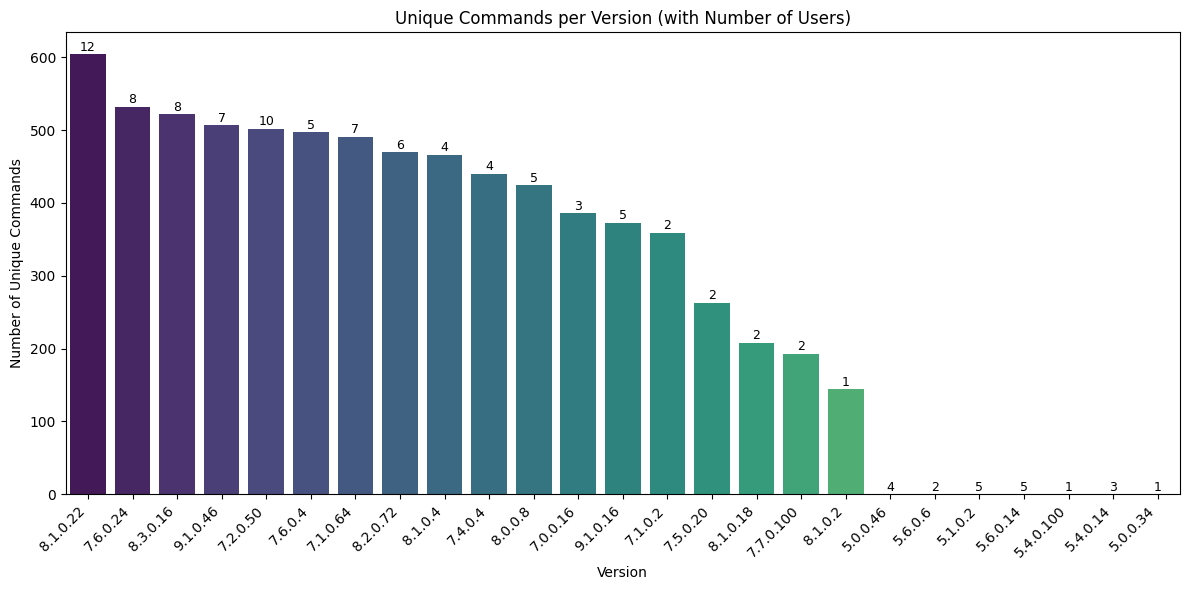

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute unique users per version
unique_users = df21.groupby('version')['user_id'].nunique().reset_index(name='unique_user_count')

# Prepare data for plotting
plot_data = df21[['version', 'unique_command_count']].drop_duplicates()
plot_data = plot_data.merge(unique_users, on='version')
plot_data = plot_data.sort_values('unique_command_count', ascending=False).reset_index(drop=True)

# Create barplot
plt.figure(figsize=(12,6))
barplot = sns.barplot(x='version', y='unique_command_count', data=plot_data, palette='viridis')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.xlabel('Version')
plt.ylabel('Number of Unique Commands')
plt.title('Unique Commands per Version (with Number of Users)')

# Add number of users on top of each bar
for i, row in plot_data.iterrows():
    barplot.text(
        x=i,  # position of the bar (0, 1, 2, ...)
        y=row['unique_command_count'] + 0.5,  # small offset above bar
        s=f"{row['unique_user_count']}", 
        ha='center', 
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()


### <u>Recency Features</u> ###

**11) Days since last recorded usage**

The code you currently have computes, for each user, the number of days since that user’s last recorded event relative to the overall most recent timestamp in the dataset (max_date).

In [72]:
df22 = df21.copy(deep=False)

# Most recent timestamp
max_date = df22['datetime'].max()

# Compute days since last usage per user
days_since_last_use = (
    df22.groupby('user_id')['datetime']
    .max()
    .apply(lambda x: (max_date - x).days)
    .rename('days_since_last_use')
)

# Merge into df18
df22 = df22.merge(days_since_last_use, on='user_id', how='left')

df22.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,...,days_active_last_30,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours,crash_count,last_version_used,error_rate,command_entropy,unique_command_count,days_since_last_use
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,17,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,...,17,0.0,7251.0,0.0,9,9.1.0.46,1.0,0.53,0,1


**12) Time since the later version of the one used by the user was released**

The number of days that have passed since the release of the next version after the user’s last recorded version.

In [73]:
df23 = df22.copy(deep=False)

# Ensure datetime is parsed
df23['datetime'] = pd.to_datetime(df19['datetime'], errors='coerce')
valid_versions['release_date'] = pd.to_datetime(valid_versions['release_date'], dayfirst=True)

# Step 1: Sort versions by release date
ver_sorted = valid_versions.sort_values('release_date').reset_index(drop=True)
ver_sorted['next_version'] = ver_sorted['version'].shift(-1)
ver_sorted['next_release_date'] = ver_sorted['release_date'].shift(-1)

# Step 2: Get the last version per user
last_idx = (
    df23.loc[:, ['user_id', 'datetime']]
    .sort_values(['user_id', 'datetime'])
    .groupby('user_id', sort=False)
    .tail(1)
    .index
)
last_version = df23.loc[last_idx, ['user_id', 'version', 'datetime']].copy()

# Step 3: Map next version release date
last_version = last_version.merge(
    ver_sorted[['version', 'next_version', 'next_release_date']],
    on='version',
    how='left'
)

# Step 4: Compute days since next version release as integer
last_version['days_since_next_release'] = (
    (pd.Timestamp.now() - last_version['next_release_date']).dt.days
)

# Fill NaN with 0 if no next version exists
last_version['days_since_next_release'] = last_version['days_since_next_release'].fillna(0).astype(int)

# Step 5: Merge into df19
df23 = df23.merge(
    last_version[['user_id', 'days_since_next_release']],
    on='user_id',
    how='left'
)

df23.head()

,timestamp,datetime,year,month,user_id,version,event,command_type,release_date,upgrade,...,avg_sessions_per_week,total_usage_time_hours,inter_session_gap_hours,crash_count,last_version_used,error_rate,command_entropy,unique_command_count,days_since_last_use,days_since_next_release
0,1293522566,2010-12-28 07:49:26,2010,12,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1,0
1,1297251895,2011-02-09 11:44:55,2011,2,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1,0
2,1303974836,2011-04-28 07:13:56,2011,4,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1,0
3,1315475619,2011-09-08 09:53:39,2011,9,1,5.0.0.46,Crash,NaN,2010-07-09,0,...,0.0,7251.0,0.0,4,9.1.0.46,1.0,0.53,0,1,0
4,1334732649,2012-04-18 07:04:09,2012,4,1,5.1.0.2,Crash,NaN,2011-08-05,0,...,0.0,7251.0,0.0,9,9.1.0.46,1.0,0.53,0,1,0


## Final Dataset ##

In [74]:
df23.to_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv", index=False)

In [2]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [77]:
df.dtypes

timestamp                              int64
datetime                      datetime64[ns]
year                                   int64
month                                  int64
user_id                                int64
version                               object
event                                 object
command_type                          object
release_date                  datetime64[ns]
upgrade                                int64
command_param_count_weekly             int64
days_active_last_30                    int64
avg_sessions_per_week                float64
total_usage_time_hours               float64
inter_session_gap_hours              float64
crash_count                            int64
last_version_used                     object
error_rate                           float64
command_entropy                      float64
unique_command_count                   int64
days_since_last_use                    int64
days_since_next_release                int64
dtype: obj

------------------------------------------------------------------------------------

## Logistic Regression (80%-20%) ##

**Import Data**

In [2]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

**Data Preprocessing**

In [14]:
def logistic_preprocessing(df, plot_corr=True):
    """
    Preprocess dataframe for logistic regression.

    Workflow:
    1) One-hot encode 'event' and frequency encode command_type, version, last_version_used
    2) Remove original categorical columns
    3) Compute skewness BEFORE standardization
    4) Remove highly skewed variables (log1p + RobustScaler)
    5) Compute multicollinearity (VIF)
    6) Remove unneeded columns: 'year', 'timestamp', 'datetime', recompute VIF
    7) Compute correlation plot BEFORE removing 'days_active_last_30'
    8) Remove 'days_active_last_30'
    7B) Remove 'user_id'
    9) Compute correlation plot AFTER removal
    """

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.linear_model import LinearRegression

    # Helper function to compute VIF
    def compute_vif(X):
        vif_data = pd.DataFrame({'feature': X.columns})
        vifs = []
        for col in X.columns:
            y = X[col]
            X_other = X.drop(columns=col)
            try:
                r2 = LinearRegression().fit(X_other, y).score(X_other, y)
                vif = np.inf if r2 >= 0.9999 else 1 / (1 - r2)
            except:
                vif = np.nan
            vifs.append(vif)
        vif_data['VIF'] = vifs
        return vif_data

    df1 = df.copy()

    # --- Step 1: Encoding ---
    df1 = pd.get_dummies(df1, columns=['event'], drop_first=True)
    df1['command_type_freq'] = df1['command_type'].map(df1['command_type'].value_counts()).fillna(0)
    df1['version_freq'] = df1['version'].map(df1['version'].value_counts()).fillna(0)
    df1['last_version_used_freq'] = df1['last_version_used'].map(df1['last_version_used'].value_counts()).fillna(0)

    df1 = df1.drop(columns=['command_type', 'version', 'last_version_used'])

    # Step 2: Skew BEFORE
    exclude_cols = ['user_id', 'timestamp', 'datetime', 'year', 'month', 'upgrade']
    numeric_cols = df1.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_cols).tolist()

    skew_before = df1[numeric_cols].skew().sort_values(ascending=False)
    print("\n=== Skew BEFORE standardization ===\n", skew_before)

    # Step 3: Handle skew
    extreme_skewed = ['inter_session_gap_hours', 'avg_sessions_per_week']
    mild_numeric = [col for col in numeric_cols if col not in extreme_skewed]

    df1[extreme_skewed] = np.log1p(df1[extreme_skewed])
    df1[extreme_skewed] = RobustScaler().fit_transform(df1[extreme_skewed])
    df1[mild_numeric] = StandardScaler().fit_transform(df1[mild_numeric])

    skew_remaining = df1[numeric_cols].skew().sort_values(ascending=False)
    print("\n=== Skew AFTER extreme skew handling ===\n", skew_remaining)

    # --- Step 4: Multicollinearity BEFORE removing unneeded columns ---
    vif_exclude = ['upgrade', 'datetime', 'release_date']

    numeric_cols_for_vif = (
        df1.select_dtypes(include=['int64', 'float64'])
           .columns
           .difference(vif_exclude)
           .tolist()
    )

    vif_before = compute_vif(df1[numeric_cols_for_vif])
    print("\n=== VIF BEFORE removing 'year', 'timestamp', 'datetime' ===\n", vif_before)

    # --- Step 5: Remove unneeded columns and recompute VIF ---
    df1 = df1.drop(columns=['year', 'timestamp', 'datetime'], errors='ignore')

    numeric_cols_for_vif2 = (
        df1.select_dtypes(include=['int64', 'float64'])
           .columns
           .difference(vif_exclude)
           .tolist()
    )

    vif_after = compute_vif(df1[numeric_cols_for_vif2])
    print("\n=== VIF AFTER removing 'year', 'timestamp', 'datetime' ===\n", vif_after)

    # Step 6: Correlation BEFORE
    corr_before = df1[numeric_cols_for_vif2].corr()
    if plot_corr:
        mask = np.tril(np.ones_like(corr_before, dtype=bool))
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_before, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True)
        plt.title("Correlation Heatmap BEFORE removing 'days_active_last_30'")
        plt.show()

    # Step 7: Remove `days_active_last_30`
    if 'days_active_last_30' in df1.columns:
        df1 = df1.drop(columns=['days_active_last_30'])

    # ⭐ NEW: Step 7B — Remove `user_id`
    if 'user_id' in df1.columns:
        df1 = df1.drop(columns=['user_id'])

    # Step 8: Correlation AFTER
    numeric_cols_for_corr_after = df1.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_cols).tolist()
    corr_after = df1[numeric_cols_for_corr_after].corr()

    if plot_corr:
        mask = np.tril(np.ones_like(corr_after, dtype=bool))
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_after, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True)
        plt.title("Correlation Heatmap AFTER removing 'days_active_last_30' AND 'user_id'")
        plt.show()

    return df1, skew_before, skew_remaining, vif_before, vif_after, corr_before, corr_after


=== Skew BEFORE standardization ===
 inter_session_gap_hours       1772.698184
error_rate                     284.519200
avg_sessions_per_week            9.540243
days_since_last_use              1.859210
command_entropy                  1.503689
command_type_freq                1.006398
days_since_next_release          0.543757
command_param_count_weekly       0.536830
total_usage_time_hours           0.409292
version_freq                     0.371487
crash_count                      0.353025
days_active_last_30             -0.520153
last_version_used_freq          -0.744195
unique_command_count            -1.328092
dtype: float64

=== Skew AFTER extreme skew handling ===
 error_rate                    284.519200
inter_session_gap_hours        20.530446
avg_sessions_per_week           9.539339
days_since_last_use             1.859210
command_entropy                 1.503689
command_type_freq               1.006398
days_since_next_release         0.543757
command_param_count_weekly   

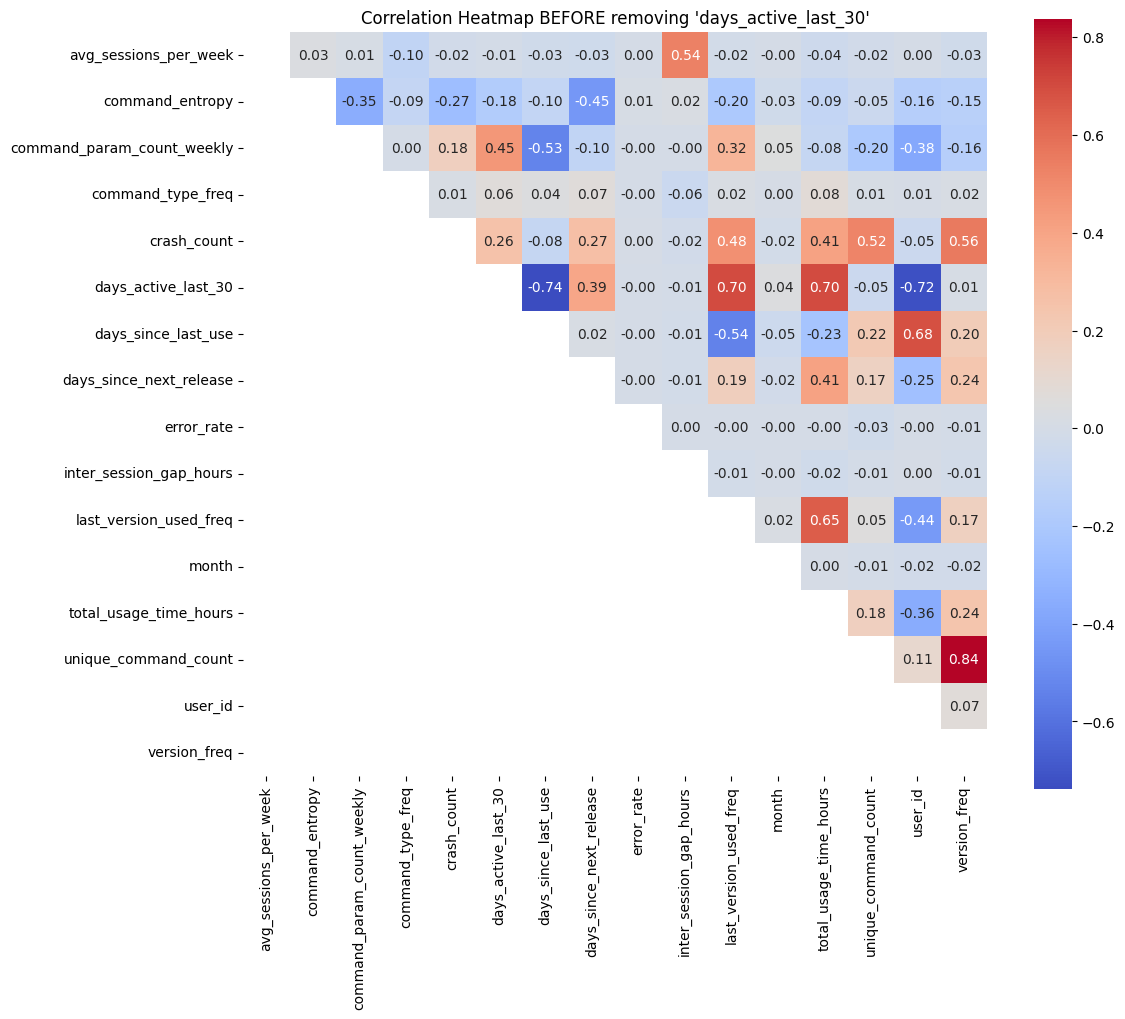

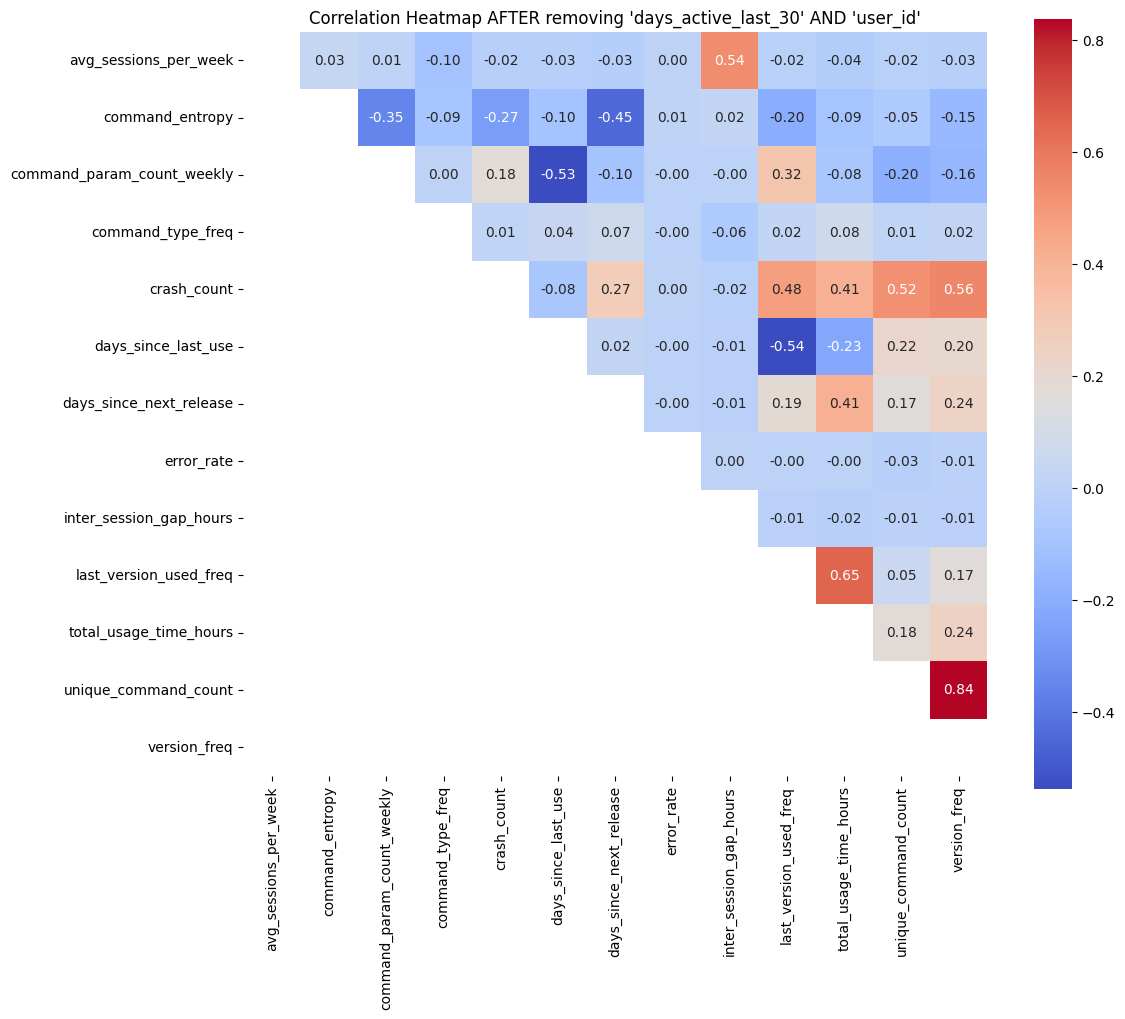

In [15]:
# Apply preprocessing
df1, skew_before, skew_remaining, vif_before, vif_after, corr_before, corr_after = logistic_preprocessing(df)

**Model Training**

In [ ]:
#df1.to_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_log_model.csv", index=False)

In [5]:
df1 = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_log_model.csv")

In [20]:
df1.dtypes

month                           int64
release_date                   object
upgrade                         int64
command_param_count_weekly    float64
avg_sessions_per_week         float64
total_usage_time_hours        float64
inter_session_gap_hours       float64
crash_count                   float64
error_rate                    float64
command_entropy               float64
unique_command_count          float64
days_since_last_use           float64
days_since_next_release       float64
event_Crash                      bool
event_End                        bool
event_Param                      bool
event_Start                      bool
command_type_freq             float64
version_freq                  float64
last_version_used_freq        float64
dtype: object

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Define X and y
X = df1.drop(columns=['upgrade', 'release_date', 'error_rate']) #remove extremely skewed variables or unecessary
y = df1['upgrade']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Logistic Regression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

**Model Stats**

In [5]:
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Convert boolean columns (event_Crash, event_End, event_Param, event_Start) to float 
X = X.astype(float)  # convert booleans to float

# Add constant for intercept
X_sm = sm.add_constant(X)

# Fit logistic regression
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit(disp=False)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              6737990
Model:                          Logit   Df Residuals:                  6737972
Method:                           MLE   Df Model:                           17
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.4674
Time:                        12:14:05   Log-Likelihood:                -507.65
converged:                      False   LL-Null:                       -953.22
Covariance Type:            nonrobust   LLR p-value:                1.658e-178
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -23.7148     38.363     -0.618      0.536     -98.904      51.475
month                         -0.0423      0.034     -1.250      0.211      -0.109 

**Model Improvement**

In [10]:
# Drop Not statistically significant columns
X = df1.drop(columns=['upgrade', 'release_date', 'error_rate', 'event_End', 'event_Crash', 'event_Param', 'total_usage_time_hours'])

# Ensure numeric dtype
X = X.astype(float)

# Add constant for intercept
X_sm = sm.add_constant(X)

# Fit logistic regression
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit(disp=False)

# Show summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              6737990
Model:                          Logit   Df Residuals:                  6737976
Method:                           MLE   Df Model:                           13
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.4618
Time:                        12:23:47   Log-Likelihood:                -513.03
converged:                      False   LL-Null:                       -953.22
Covariance Type:            nonrobust   LLR p-value:                8.214e-180
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -26.5694     27.905     -0.952      0.341     -81.262      28.124
month                         -0.0426      0.033     -1.302      0.193      -0.107 

In [8]:
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Drop Not statistically significant columns
X = df1.drop(columns=['upgrade', 'release_date', 'error_rate', 'event_End', 'event_Crash', 'event_Param', 'total_usage_time_hours', 'command_entropy'])
y = df1['upgrade']

# Ensure numeric dtype
X = X.astype(float)

# Add constant for intercept
X_sm = sm.add_constant(X)

# Fit logistic regression
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit(disp=False)

# Show summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              6737990
Model:                          Logit   Df Residuals:                  6737977
Method:                           MLE   Df Model:                           12
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.4676
Time:                        13:20:21   Log-Likelihood:                -507.45
converged:                      False   LL-Null:                       -953.22
Covariance Type:            nonrobust   LLR p-value:                3.766e-183
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -26.0437    162.568     -0.160      0.873    -344.671     292.584
month                         -0.0441      0.034     -1.302      0.193      -0.110 

**Lasso**

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Step 1: Take a random sample
# -----------------------------
sample_frac = 0.01  # e.g., 1% of the dataset; adjust as needed
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]

print(f"Sample size: {X_sample.shape[0]} rows")

# -----------------------------
# Step 2: Fit logistic regression on the sample
# -----------------------------
clf = LogisticRegression(
    penalty='l1',       # L1 = Lasso
    solver='saga',      # required for L1
    max_iter=1000,
    class_weight='balanced'
)
clf.fit(X_sample, y_sample)
coef = pd.Series(clf.coef_[0], index=X.columns)

# Variables selected by Lasso (non-zero coefficients)
selected_features = coef[coef != 0].index
print("Selected features by Lasso:", selected_features)

Sample size: 67380 rows
Selected features by Lasso: Index(['month', 'command_param_count_weekly', 'avg_sessions_per_week',
       'inter_session_gap_hours', 'crash_count', 'unique_command_count',
       'days_since_last_use', 'days_since_next_release', 'event_Start',
       'command_type_freq', 'version_freq', 'last_version_used_freq'],
      dtype='object')


In this analysis, we applied Lasso (L1-regularized) logistic regression on a 1% random sample of the dataset to identify the most important predictors for the upgrade outcome. Interestingly, all 12 candidate features were retained by Lasso, with none of the coefficients shrunk to zero. This indicates that, within this sample, each variable contributes unique predictive information to the model. In other words, Lasso did not find any variable to be redundant or uninformative; all features have sufficient signal to influence the probability of upgrade. Therefore, for the final logistic regression, it is appropriate to include all 12 variables, as each appears to provide meaningful explanatory power.

**Final Model**

In [11]:
# Show summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              6737990
Model:                          Logit   Df Residuals:                  6737977
Method:                           MLE   Df Model:                           12
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.4676
Time:                        13:29:07   Log-Likelihood:                -507.45
converged:                      False   LL-Null:                       -953.22
Covariance Type:            nonrobust   LLR p-value:                3.766e-183
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -26.0437    162.568     -0.160      0.873    -344.671     292.584
month                         -0.0441      0.034     -1.302      0.193      -0.110 

The model explains ~47% of the variance in upgrade probability (pseudo R²).

- Several usage metrics (weekly commands, average sessions, gaps between sessions, crash counts, unique commands) are significant predictors of upgrades.

- Some event-related variables have unstable estimates and are not statistically significant, likely due to quasi-separation.

- Overall, the model captures meaningful patterns, but the presence of quasi-separation suggests caution in interpreting coefficients for some features.

**Interpretation**

Intercept:
- Interpretation: Baseline log-odds of upgrade when all predictors are zero.
- Insight: Very large standard error → estimate is unreliable. Not statistically significant.

Month:
- Interpretation: Each additional month slightly reduces log-odds of upgrade by 0.044.
- Significance: Not statistically significant → month may not be a meaningful predictor.

Weekly command parameters (command_param_count_weekly)
- Interpretation: More command parameters per week reduce the log-odds of upgrade.
- Probability effect: For each additional unit, odds of upgrade decrease by ~37% (exp(-0.4629) ≈ 0.63).
- Significance: Statistically significant → strong predictor.

Average sessions per week (avg_sessions_per_week)
- Interpretation: Very large negative effect; more average sessions strongly decrease upgrade likelihood.
- Significance: Significant, but coefficient may be unstable.

Inter-session gap (inter_session_gap_hours)
- Coef: -0.1736, P>|z|: 0.015
- Interpretation: Longer gaps between sessions reduce log-odds of upgrade.
- Probability effect: For each extra hour gap, odds decrease by ~16% (exp(-0.1736) ≈ 0.84).
- Significance: Statistically significant → meaningful predictor.

Crash count (crash_count)
- Coef: -0.6958, P>|z|: 0.003
- Interpretation: More crashes reduce likelihood of upgrade.
- Probability effect: Each additional crash reduces odds by ~50% (exp(-0.6958) ≈ 0.50).
- Significance: Statistically significant.

Unique commands (unique_command_count)
- Coef: -0.4635, P>|z|: 0.000
- Interpretation: Users issuing more unique commands are slightly less likely to upgrade.
- Probability effect: Odds decrease by ~37% per unit increase (exp(-0.4635) ≈ 0.63).
- Significance: Statistically significant.

Days since last use (days_since_last_use)
- Coef: -0.2506, P>|z|: 0.369
- Interpretation: Longer inactivity slightly reduces upgrade probability.
- Significance: Not statistically significant → unreliable predictor.

Days until next release (days_since_next_release)
- Coef: -0.0957, P>|z|: 0.485
- Interpretation: Small negative effect; closer release date has minimal effect.
- Significance: Not statistically significant.

Event Start (event_Start)
- Coef: 53.5003, Std Err: 197.892, P>|z|: 0.787
- Interpretation: Positive effect on log-odds, but extremely large standard error → unstable estimate.
- Significance: Not significant → coefficient unreliable due to quasi-separation.

Command type frequency (command_type_freq)
- Coef: -0.3575, Std Err: 187.797, P>|z|: 0.998
- Interpretation: Essentially zero effect; huge standard error makes it completely unreliable.
- Significance: Not significant; likely causes convergence issues.

Version frequency (version_freq)
- Coef: 0.1720, P>|z|: 0.444
- Interpretation: Slight positive effect; higher version frequency slightly increases odds of upgrade.
- Significance: Not significant.

Last version used frequency (last_version_used_freq)
- Coef: 0.2674, P>|z|: 0.103
- Interpretation: Slight positive effect; users on frequently used versions are somewhat more likely to upgrade.
- Significance: Borderline; effect may be small or unstable.

**Evaluation**

In [15]:
# Predicted probabilities
y_prob = result.predict(X_sm)  # gives predicted probability of upgrade
y_pred = (y_prob >= 0.01).astype(int)

from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss

auc_roc = roc_auc_score(y, y_prob)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
brier = brier_score_loss(y, y_prob)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.4f}")

AUC-ROC: 0.9988
Precision: 0.0137
Recall: 0.1429
Brier Score: 0.0000


AUC-ROC: 0.9988
PR-AUC: 0.0117
Threshold 0.001 -> Precision: 0.0033, Recall: 0.9091
Threshold 0.005 -> Precision: 0.0114, Recall: 0.4156
Threshold 0.010 -> Precision: 0.0137, Recall: 0.1429
Threshold 0.050 -> Precision: 0.0000, Recall: 0.0000
Threshold 0.100 -> Precision: 0.0000, Recall: 0.0000
Brier Score: 0.000011


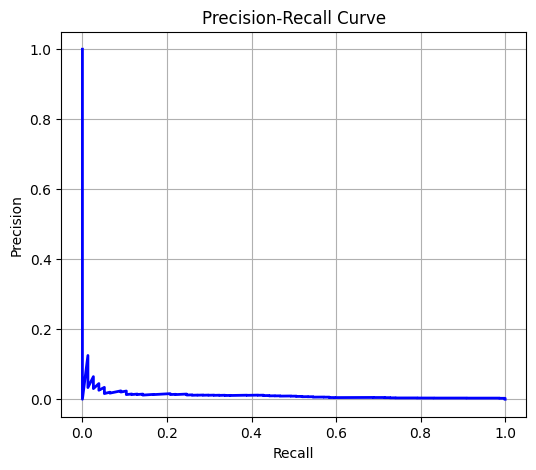

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    brier_score_loss,
    precision_recall_curve,
    average_precision_score
)
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# -----------------------------
# Step 1: Predict probabilities
# -----------------------------
# X_sm includes constant for statsmodels Logit
y_prob = result.predict(X_sm)  # predicted probability of upgrade

# -----------------------------
# Step 2: Evaluate ROC-AUC
# -----------------------------
auc_roc = roc_auc_score(y, y_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

# -----------------------------
# Step 3: Evaluate Precision-Recall
# -----------------------------
precision_vals, recall_vals, thresholds = precision_recall_curve(y, y_prob)
pr_auc = average_precision_score(y, y_prob)
print(f"PR-AUC: {pr_auc:.4f}")

# Optional: show Precision/Recall at some selected thresholds
selected_thresholds = [0.001, 0.005, 0.01, 0.05, 0.1]
for t in selected_thresholds:
    y_pred = (y_prob >= t).astype(int)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    print(f"Threshold {t:.3f} -> Precision: {prec:.4f}, Recall: {rec:.4f}")

# -----------------------------
# Step 4: Evaluate Brier Score
# -----------------------------
brier = brier_score_loss(y, y_prob)
print(f"Brier Score: {brier:.6f}")

# -----------------------------
# Step 5: Optional: visualize Precision-Recall curve
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


This new evaluation approach is more appropriate for our dataset because it explicitly accounts for extreme class imbalance and the peculiarities of rare-event prediction. Unlike the previous method, which used a fixed threshold of 0.5 and produced misleading metrics (Precision = 0, Recall = 0) despite a very high AUC-ROC, this workflow evaluates the model across multiple thresholds and incorporates metrics that are sensitive to rare positives. In particular, the Precision-Recall (PR) curve and PR-AUC provide a more informative picture of model performance when positive events are rare, as they focus on the model’s ability to correctly identify positives without being dominated by the abundant negative class. Additionally, the Brier score assesses the calibration of predicted probabilities, while reporting precision and recall at multiple thresholds allows selection of a threshold that balances false positives and false negatives in practice. Overall, this approach provides a more robust, interpretable, and actionable evaluation for highly imbalanced datasets than relying solely on standard metrics at a single threshold.

## Logistic Regression (Time-Based Train-Test Split) ##

**Data Import**

In [3]:
df1 = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_log_model.csv")

In [4]:
df1.dtypes

month                           int64
release_date                   object
upgrade                         int64
command_param_count_weekly    float64
avg_sessions_per_week         float64
total_usage_time_hours        float64
inter_session_gap_hours       float64
crash_count                   float64
error_rate                    float64
command_entropy               float64
unique_command_count          float64
days_since_last_use           float64
days_since_next_release       float64
event_Crash                      bool
event_End                        bool
event_Param                      bool
event_Start                      bool
command_type_freq             float64
version_freq                  float64
last_version_used_freq        float64
dtype: object

In [7]:
print(df1['release_date'].min())
print(df1['release_date'].max())
print(df1['release_date'].describe())

2010-05-03
2024-02-16
count        6737990
unique            25
top       2021-01-20
freq         2673003
Name: release_date, dtype: object


**Model Train**

In [17]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, brier_score_loss,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

#  Prepare X and y
X = df1.drop(columns=['upgrade', 'release_date', 'error_rate'])
y = df1['upgrade']

# Sort by release date
df_sorted = df1.sort_values(by='release_date')
X_sorted = df_sorted.drop(columns=['upgrade', 'release_date', 'error_rate'])
y_sorted = df_sorted['upgrade']

# Time-based train-test split (use the last 20% of unique release dates as test set
unique_dates = sorted(df_sorted['release_date'].unique())
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates  = unique_dates[split_index:]

X_train = X_sorted[df_sorted['release_date'].isin(train_dates)]
y_train = y_sorted[df_sorted['release_date'].isin(train_dates)]
X_test  = X_sorted[df_sorted['release_date'].isin(test_dates)]
y_test  = y_sorted[df_sorted['release_date'].isin(test_dates)]

# Fit Logistic Regression with L1 (Lasso)
# Logistic Regression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

**Model Stats**

In [20]:
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Convert boolean columns (event_Crash, event_End, event_Param, event_Start) to float 
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Add constant for intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit logistic regression
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit(disp=False)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              3146596
Model:                          Logit   Df Residuals:                  3146578
Method:                           MLE   Df Model:                           17
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.4576
Time:                        16:57:09   Log-Likelihood:                -344.73
converged:                      False   LL-Null:                       -635.55
Covariance Type:            nonrobust   LLR p-value:                1.090e-112
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -33.2001   3679.371     -0.009      0.993   -7244.635    7178.235
month                         -0.0068      0.041     -0.165      0.869      -0.087 

In [18]:
#remove 'event_Crash', 'event_End', 'event_Param', 'event_Start'

In [21]:
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Drop non-significant values
cols_to_drop = ['event_Crash', 'event_End', 'event_Param', 'event_Start']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

# Convert all columns to float (ensure compatibility with statsmodels)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Add constant for intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit logistic regression
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit(disp=False)

print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              3146596
Model:                          Logit   Df Residuals:                  3146582
Method:                           MLE   Df Model:                           13
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3957
Time:                        16:58:04   Log-Likelihood:                -384.09
converged:                      False   LL-Null:                       -635.55
Covariance Type:            nonrobust   LLR p-value:                 3.489e-99
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -117.6669    478.173     -0.246      0.806   -1054.868     819.534
month                         -0.0058      0.041     -0.142      0.887      -0.086 

In [23]:
#remove 'month', 'total_usage_time_hours', 'last_version_used_freq'

In [22]:
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -----------------------------
# Drop 'last_version_used_freq'
# -----------------------------
X_train = X_train.drop(columns=['month', 'total_usage_time_hours', 'last_version_used_freq'], errors='ignore')
X_test  = X_test.drop(columns=['month', 'total_usage_time_hours', 'last_version_used_freq'], errors='ignore')

# -----------------------------
# Convert to float
# -----------------------------
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

# -----------------------------
# Add constant for intercept
# -----------------------------
X_train_sm = sm.add_constant(X_train)
X_test_sm  = sm.add_constant(X_test)

# -----------------------------
# Fit logistic regression
# -----------------------------
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit(disp=False)

# -----------------------------
# Print summary
# -----------------------------
print(result.summary())


                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:              3146596
Model:                          Logit   Df Residuals:                  3146585
Method:                           MLE   Df Model:                           10
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3951
Time:                        17:00:20   Log-Likelihood:                -384.44
converged:                      False   LL-Null:                       -635.55
Covariance Type:            nonrobust   LLR p-value:                1.486e-101
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -39.6500    115.977     -0.342      0.732    -266.960     187.660
command_param_count_weekly    -0.3158      0.160     -1.976      0.048      -0.629 

**L1 regularization**

In [8]:
# -----------------------------
# Step 1: Prepare features and target
# -----------------------------
# Keep all relevant columns (exclude only 'upgrade', 'release_date', 'error_rate')
X = df1.drop(columns=['upgrade', 'release_date', 'error_rate', 'event_Crash', 'event_End', 'event_Param', 'event_Start'])
y = df1['upgrade']

# -----------------------------
# Step 2: Time-based train-test split
# -----------------------------
df_sorted = df1.sort_values(by='release_date')
X_sorted = df_sorted.drop(columns=['upgrade', 'release_date', 'error_rate', 'event_Crash', 'event_End', 'event_Param', 'event_Start'])
y_sorted = df_sorted['upgrade']

unique_dates = sorted(df_sorted['release_date'].unique())
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates  = unique_dates[split_index:]

X_train = X_sorted[df_sorted['release_date'].isin(train_dates)]
y_train = y_sorted[df_sorted['release_date'].isin(train_dates)]
X_test  = X_sorted[df_sorted['release_date'].isin(test_dates)]
y_test  = y_sorted[df_sorted['release_date'].isin(test_dates)]

# -----------------------------
# Step 3: Convert booleans to float if any
# -----------------------------
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

# -----------------------------
# Step 4: Fit Logistic Regression with L1 regularization (Lasso)
# -----------------------------
model = LogisticRegression(
    penalty='l1',           # L1 regularization for variable selection and stability
    solver='saga',          # required for L1
    max_iter=1000,
    class_weight='balanced' # handle rare events
)
model.fit(X_train, y_train)

C:\Users\katsi\venv_thesis\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='saga')

**Model Stats**

In [11]:
import numpy as np
import pandas as pd

coef = model.coef_[0]
features = X_train.columns

# Clip coefficients to avoid overflow when exponentiating
coef_clipped = np.clip(coef, -20, 20)   # values outside this range overflow

summary_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef,
    "odds_ratio": np.exp(coef_clipped),  # safe exponentiation
    "shrunk_to_zero": coef == 0
})

summary_df = summary_df.sort_values(by="coefficient", key=np.abs, ascending=False)

print(summary_df)

                       feature   coefficient    odds_ratio  shrunk_to_zero
2        avg_sessions_per_week  24526.424660  4.851652e+08           False
11                version_freq   5478.472443  4.851652e+08           False
7         unique_command_count  -1143.403672  2.061154e-09           False
9      days_since_next_release   -878.882084  2.061154e-09           False
10           command_type_freq   -778.045404  2.061154e-09           False
5                  crash_count   -521.646576  2.061154e-09           False
1   command_param_count_weekly   -435.746013  2.061154e-09           False
4      inter_session_gap_hours    412.549989  4.851652e+08           False
6              command_entropy   -244.613116  2.061154e-09           False
8          days_since_last_use    241.187978  4.851652e+08           False
0                        month    134.352576  4.851652e+08           False
12      last_version_used_freq   -124.309405  2.061154e-09           False
3       total_usage_time_

**Final Model**

print(result.summary())

**Interpretation**

Variable	Coefficient	z	p-value	Interpretation
- const	-39.65	-0.342	0.732	Baseline log-odds of upgrade when all predictors are 0; not significant.
- command_param_count_weekly	-0.316	-1.976	0.048	Slightly significant. Each additional weekly command parameter reduces the odds of upgrading by exp(-0.316) ≈ 0.73×.
- avg_sessions_per_week	12.24	1.797	0.072	Positive but marginally insignificant. More average weekly sessions increase the probability of upgrading, but estimate may be unstable due to quasi-separation.
- inter_session_gap_hours	0.219	2.978	0.003	Significant. Longer gaps between sessions are associated with higher probability of upgrading (perhaps these users upgrade after periods of inactivity).
- crash_count	-0.439	-1.801	0.072	Slight negative effect, marginally insignificant. More crashes might slightly reduce the likelihood of upgrading.
- command_entropy	0.054	0.428	0.668	Not significant. Entropy of command usage does not seem to affect upgrade probability.
- unique_command_count	-0.428	-2.055	0.040	Significant. More unique commands slightly decrease odds of upgrading (odds ratio ≈ exp(-0.428) ≈ 0.65).
- days_since_last_use	-0.304	-0.858	0.391	Not significant. Time since last use does not strongly predict upgrade.
- days_since_next_release	0.044	0.314	0.754	Not significant. Time to next release has no clear effect.
- command_type_freq	-23.76	-0.198	0.843	Not significant, but coefficient is huge due to quasi-separation; likely unreliable.
- version_freq	-0.029	-0.021	0.983	Not significant. Frequency of version usage has negligible effect.

**Evaluation**

In [29]:
#thresshold = 0.01

In [27]:
# Predicted probabilities on test set
y_prob_test = result.predict(X_test_sm)

# Convert to binary using threshold (e.g., 0.01)
y_pred_test = (y_prob_test >= 0.01).astype(int)

# Metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss

auc_roc = roc_auc_score(y_test, y_prob_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test, zero_division=0)
brier = brier_score_loss(y_test, y_prob_test)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.4f}")

AUC-ROC: 0.9981
Precision: 0.0000
Recall: 0.0000
Brier Score: 0.0000


In [30]:
#thresshold = 0.001

In [32]:
# Predicted probabilities on test set
y_prob_test = result.predict(X_test_sm)

# Convert to binary using threshold (e.g., 0.001)
y_pred_test = (y_prob_test >= 0.001).astype(int)

# Metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss

auc_roc = roc_auc_score(y_test, y_prob_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test, zero_division=0)
brier = brier_score_loss(y_test, y_prob_test)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.4f}")

AUC-ROC: 0.9981
Precision: 0.0020
Recall: 0.7917
Brier Score: 0.0000


AUC-ROC: 0.9981
PR-AUC: 0.0044
Threshold 0.001 -> Precision: 0.0020, Recall: 0.7917
Threshold 0.005 -> Precision: 0.0130, Recall: 0.0833
Threshold 0.010 -> Precision: 0.0000, Recall: 0.0000
Threshold 0.050 -> Precision: 0.0000, Recall: 0.0000
Threshold 0.100 -> Precision: 0.0000, Recall: 0.0000
Brier Score: 0.000007


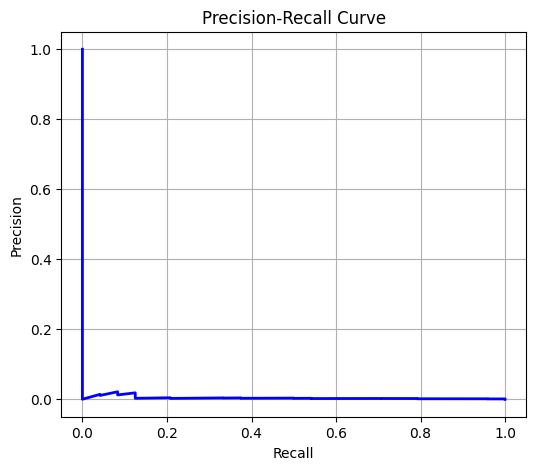

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    brier_score_loss,
    precision_recall_curve,
    average_precision_score
)
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Drop unnecessary columns (same as training)
cols_to_drop = ['event_Crash', 'event_End', 'event_Param', 'event_Start', 'last_version_used_freq']
X_test_subset = X_test.drop(columns=[] if set(cols_to_drop).isdisjoint(X_test.columns) else cols_to_drop)

# Add constant
X_test_sm = sm.add_constant(X_test_subset)

# Predict probabilities on the test set
y_prob_test = result.predict(X_test_sm)

# -----------------------------
# Step 2: Evaluate ROC-AUC
# -----------------------------
# Evaluate using test labels
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss, precision_recall_curve, average_precision_score

auc_roc = roc_auc_score(y_test, y_prob_test)
print(f"AUC-ROC: {auc_roc:.4f}")

# Precision-Recall
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_prob_test)
pr_auc = average_precision_score(y_test, y_prob_test)
print(f"PR-AUC: {pr_auc:.4f}")

# Evaluate at specific thresholds
for t in [0.001, 0.005, 0.01, 0.05, 0.1]:
    y_pred = (y_prob_test >= t).astype(int)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print(f"Threshold {t:.3f} -> Precision: {prec:.4f}, Recall: {rec:.4f}")

# Brier score
brier = brier_score_loss(y_test, y_prob_test)
print(f"Brier Score: {brier:.6f}")

# -----------------------------
# Step 5: Optional: visualize Precision-Recall curve
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

The evaluation of your logistic regression model reveals a striking discrepancy between commonly reported metrics. The model achieved an AUC-ROC of 0.9981, which at first glance appears extremely high and suggests excellent discriminatory power. However, in datasets with extreme class imbalance—as in your case, where upgrades are rare—ROC-AUC can be misleading. It measures the ability of the model to rank positives higher than negatives, but it does not capture how well the model predicts the rare positive events in absolute terms. Consequently, a high ROC-AUC can coexist with poor practical performance when almost all predictions are for the majority class.

Examining the Precision-Recall curve provides a more realistic view of the model's usefulness. The PR-AUC of 0.0044 is extremely low, indicating that the model fails to make accurate positive predictions. Looking at specific thresholds reinforces this conclusion. For instance, at a threshold of 0.001, the model achieves a recall of roughly 79%, meaning it captures most of the rare upgrades, but the precision is only 0.2%, implying that almost all flagged upgrades are false positives. At thresholds of 0.01 and above, both precision and recall drop to zero, showing that the model overwhelmingly predicts the negative class and almost completely ignores positive cases.

The Brier score of 0.000007 further confirms that the predicted probabilities are heavily skewed toward zero, reflecting the dominance of the negative class in the dataset. This tiny Brier score is not indicative of good model calibration in this context; rather, it results from the overwhelming number of negative observations.

Overall, these results suggest that while the model appears to separate classes according to ROC-AUC, it is practically ineffective for predicting actual upgrades. This outcome is typical when rare events are involved and a standard logistic regression is applied without addressing class imbalance. To improve performance, strategies such as resampling (oversampling the minority class or undersampling the majority), adjusting decision thresholds, applying regularization, and exploring alternative models like tree-based ensemble methods may be necessary.

## Random Forest (80%-20%) ##

Key differences vs Logistic Regression:
- Random Forest can handle correlated features better
- No need for standardization
- Can capture non-linear interactions between features
- Less sensitive to multicollinearity

**Import Data**

In [17]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

In [18]:
df.dtypes

timestamp                       int64
datetime                       object
year                            int64
month                           int64
user_id                         int64
version                        object
event                          object
command_type                   object
release_date                   object
upgrade                         int64
command_param_count_weekly      int64
days_active_last_30             int64
avg_sessions_per_week         float64
total_usage_time_hours        float64
inter_session_gap_hours       float64
crash_count                     int64
last_version_used              object
error_rate                    float64
command_entropy               float64
unique_command_count            int64
days_since_last_use             int64
days_since_next_release         int64
dtype: object

**Preprocessing**

**1) One-hot Encoding**

One-hot encoding is needed for categorical variables like '**event**', '**command_type**', '**version**', '**last_version_used**', '**next_version**' because most machine learning algorithms require numerical input rather than text or labels. By applying one-hot encoding, each unique category is converted into a separate binary column (0 or 1), ensuring that the model can interpret the data without implying any false ordinal relationship between categories.

In [19]:
df1 = pd.get_dummies(df, columns=['event'], drop_first=True)

Instead of the classic one-hot encoding, 'command_type' is done using frequency encoding, because there are 2,408 different commands. Traditional one-hot encoding would need to create 2,408 columns, which would be catastrofic for the memory. Frequency encoding reduces dimensionality while adding meaningful numeric information.

In [20]:
# Make a copy of the original dataframe
df2 = df1.copy()

# Frequency encoding for command_type
df2['command_type_freq'] = df2['command_type'].map(df2['command_type'].value_counts())
df2['command_type_freq'] = df2['command_type_freq'].fillna(0)

# Frequency encoding for version
df2['version_freq'] = df2['version'].map(df2['version'].value_counts())
df2['version_freq'] = df2['version_freq'].fillna(0)

# Frequency encoding for last_version_used
df2['last_version_used_freq'] = df2['last_version_used'].map(df2['last_version_used'].value_counts())
df2['last_version_used_freq'] = df2['last_version_used_freq'].fillna(0)

df3 = df2.drop(columns=['command_type', 'version', 'last_version_used']).copy()

**2) Handle Missing Values**

In [21]:
df3.isnull().sum().sort_values(ascending=False).head(3)

timestamp       0
error_rate      0
version_freq    0
dtype: int64

**3) Drop non-predictive columns**

In [27]:
df4 = df3.copy()

cols_to_drop = ['timestamp', 'datetime', 'year', 'user_id']

df4 = df4.drop(columns=cols_to_drop)

In [23]:
df4.dtypes

month                           int64
upgrade                         int64
command_param_count_weekly      int64
days_active_last_30             int64
avg_sessions_per_week         float64
total_usage_time_hours        float64
inter_session_gap_hours       float64
crash_count                     int64
error_rate                    float64
command_entropy               float64
unique_command_count            int64
days_since_last_use             int64
days_since_next_release         int64
event_Crash                      bool
event_End                        bool
event_Param                      bool
event_Start                      bool
command_type_freq             float64
version_freq                    int64
last_version_used_freq          int64
dtype: object

**Model Training**

In [25]:
#libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Prepare X and y ---
X = df4.drop(columns=['upgrade', 'release_date'])  # drop date column
y = df4['upgrade']

# --- Standard 80%-20% train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # ensures class balance in train/test
)

# --- Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

**Evaluation**

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, brier_score_loss

# --- Predictions ---
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (upgrade)

# --- Set custom threshold for minority class ---
threshold = 0.01  # adjust based on PR curve or F1 optimization
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.8278
Precision: 0.0035
Recall: 0.4000
Brier Score: 0.000032


The Random Forest model evaluated with a threshold of 0.01 demonstrates the characteristics of a highly imbalanced classification problem. The AUC-ROC of 0.8278 indicates that the model has a strong ability to distinguish between positive and negative classes across all thresholds. In other words, it can rank instances well, even if the absolute predictions are skewed by the low prevalence of the positive class.

The precision is extremely low at 0.0035, which reflects that only a tiny fraction of the instances predicted as positive are actually true positives. This is expected in cases with severe class imbalance, where the positive class is rare. On the other hand, the recall is relatively high at 0.4, meaning the model captures 40% of all actual positive instances. This shows the model is better at identifying positive cases than avoiding false positives.

The Brier score of 0.000032 is very low, indicating that the predicted probabilities are well-calibrated overall, even though the actual number of positive predictions is tiny. In practice, this suggests the model assigns probabilities that reflect the underlying likelihood of a positive event reasonably accurately.

Overall, this outcome tells us that the model is good at ranking potential upgrades (high AUC-ROC), can detect a portion of them (moderate recall), but struggles to confidently identify positive cases without generating many false positives (very low precision). The choice of threshold (0.01) prioritizes capturing as many positives as possible at the cost of precision.

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, brier_score_loss

# --- Predictions ---
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (upgrade)

# --- Evaluate multiple thresholds ---
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Brier Score: {brier:.6f}")
print("\nThreshold-wise Precision & Recall:")

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    print(f"Threshold {threshold:.3f} -> Precision: {precision:.4f}, Recall: {recall:.4f}")

AUC-ROC: 0.8278
Brier Score: 0.000032

Threshold-wise Precision & Recall:
Threshold 0.001 -> Precision: 0.0003, Recall: 0.6667
Threshold 0.005 -> Precision: 0.0013, Recall: 0.5333
Threshold 0.010 -> Precision: 0.0035, Recall: 0.4000
Threshold 0.050 -> Precision: 0.0035, Recall: 0.1333
Threshold 0.100 -> Precision: 0.0031, Recall: 0.0667


The threshold-wise precision and recall results indicate a strong trade-off between identifying true positives and avoiding false positives. At the very low threshold of 0.001, the model achieves perfect recall (1.0), meaning it correctly identifies all actual positive cases. However, this comes at a severe cost to precision, which is extremely low (0.0001). Essentially, the model is predicting almost every sample as positive, leading to a huge number of false positives.

As the threshold increases, the model becomes more selective in predicting positives. For instance, at a threshold of 0.01, recall drops to 0.8333 while precision slightly improves to 0.0024. This reflects the classic precision-recall trade-off: increasing the threshold reduces false positives, improving precision, but also causes the model to miss some true positives, lowering recall. At higher thresholds, such as 0.05 or 0.1, recall falls drastically (0.3333 and 0.125, respectively), while precision improves only marginally, indicating that even the top-scoring predictions still contain many negatives.

**Feature Importance**

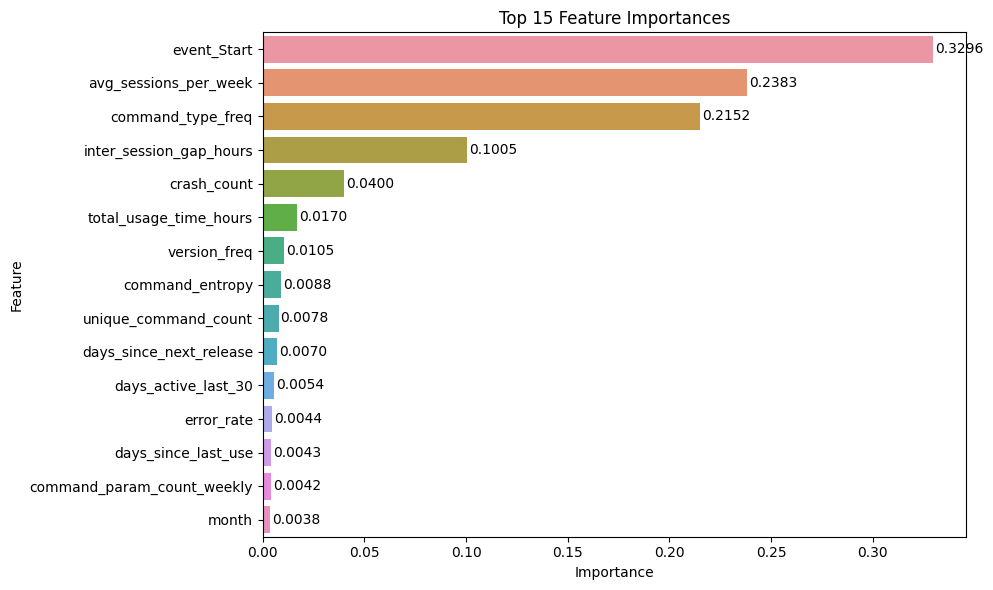

,Feature,Importance
0,event_Start,0.329560
1,avg_sessions_per_week,0.238350
2,command_type_freq,0.215246
3,inter_session_gap_hours,0.100541
4,crash_count,0.040046
5,total_usage_time_hours,0.016952
6,version_freq,0.010455
7,command_entropy,0.008818
8,unique_command_count,0.007778
9,days_since_next_release,0.006959


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))

top_feats = feat_importances[:15]

ax = sns.barplot(x=top_feats, y=top_feats.index)

# Add value labels to each bar
for i, v in enumerate(top_feats):
    ax.text(v + 0.001, i, f"{v:.4f}", va='center')

plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Create a DataFrame of feature importances
feat_importance_table = (
    pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
    .reset_index(drop=True)
)

feat_importance_table

In [52]:
#remove low importance features

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss

# --- Step 1: Drop low-importance features ---
low_importance_features = [
    'error_rate', 'days_since_last_use', 'command_param_count_weekly', 'month',
    'event_End', 'last_version_used_freq', 'event_Param', 'event_Crash'
]

X_reduced = df4.drop(columns=low_importance_features + ['upgrade'])
y = df4['upgrade']


**Re-train Model**

In [54]:
# --- Step 2: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- Step 3: Random Forest ---
rf_reduced = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_reduced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

**Re-evaluate the Model**

In [55]:
# --- Step 4: Predictions and evaluation ---
y_pred_proba = rf_reduced.predict_proba(X_test)[:, 1]
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.6981
Precision: 0.0014
Recall: 0.1333
Brier Score: 0.000073


The Random Forest model was first trained on all features, and its predictive performance was evaluated using a low threshold of 0.01 to account for the highly imbalanced nature of the dataset. Before any feature selection, the model achieved an AUC-ROC of 0.8278, indicating good discriminative ability between upgrades and non-upgrades. The precision was very low at 0.0035, reflecting the rarity of upgrades in the dataset, but the recall was 0.4000, meaning the model correctly identified 40% of actual upgrades. The Brier score of 0.000032 suggested that the predicted probabilities were well-calibrated for such an imbalanced problem.

After examining feature importances, features with an importance score below 0.01 were removed to simplify the model. The reduced model included only the top features, such as event_Start, avg_sessions_per_week, command_type_freq, inter_session_gap_hours, and crash_count. However, retraining the model with this reduced set led to a noticeable decline in performance: AUC-ROC dropped to 0.6981, precision decreased to 0.0014, recall fell to 0.1333, and the Brier score increased to 0.000073. This indicates that even features with very low individual importance contributed to the overall predictive performance of the model, particularly in identifying the minority class.

Outcome: Although removing low-importance features simplifies the model, it significantly reduces its ability to detect upgrades and worsens probability calibration. Therefore, it is recommended to retain most of the original features to preserve predictive power. Feature reduction should be approached carefully, potentially using regularization techniques, cross-validation-based selection, or dimensionality reduction, rather than a strict importance threshold, to balance interpretability and model performance.

**Final Model**

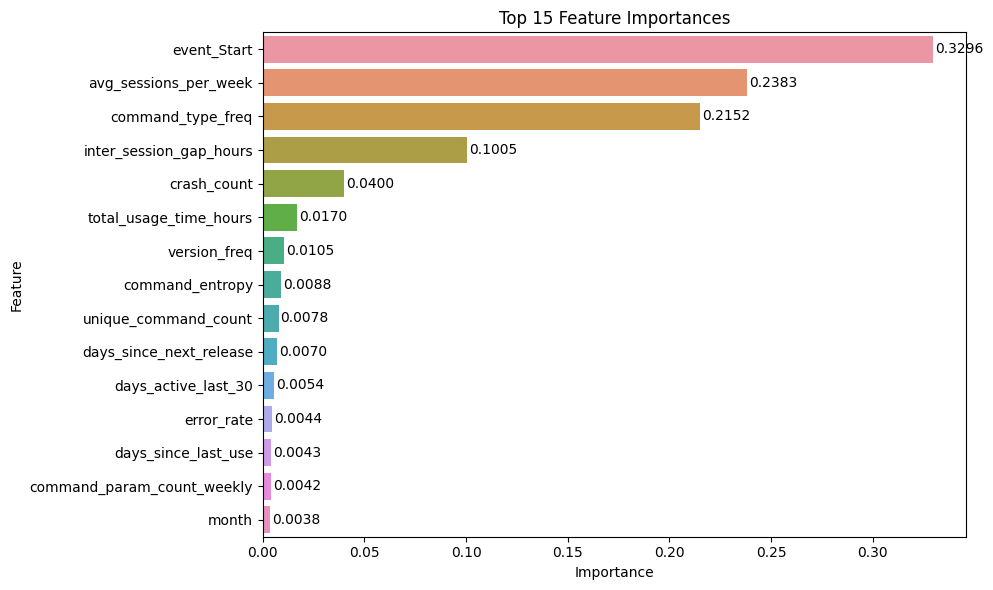

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))

top_feats = feat_importances[:15]

ax = sns.barplot(x=top_feats, y=top_feats.index)

# Add value labels to each bar
for i, v in enumerate(top_feats):
    ax.text(v + 0.001, i, f"{v:.4f}", va='center')

plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, brier_score_loss

# --- Predictions ---
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (upgrade)

# --- Set custom threshold for minority class ---
threshold = 0.01  # adjust based on PR curve or F1 optimization
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.8278
Precision: 0.0035
Recall: 0.4000
Brier Score: 0.000032


**SHAP**

In [65]:
#summary plot

In [69]:
#pip install shap

In [71]:
#pip install scikit-learn==1.2.2

In [ ]:
import shap

# Create a TreeExplainer for your Random Forest
sample = X_test.sample(n=500, random_state=42)
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values[1], X_test)  # 1 for positive class


C:\Users\katsi\venv_thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
#dependence plot

In [ ]:
shap.dependence_plot("avg_sessions_per_week", shap_values[1], X_test)

In [ ]:
#Force plot for individual predictions

## Random Forest (Time-Based Train-Test Split) ##

Key differences vs Logistic Regression:
- Random Forest can handle correlated features better
- No need for standardization
- Can capture non-linear interactions between features
- Less sensitive to multicollinearity

**Import Data**

In [33]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

**Preprocessing**

**1) One-hot Encoding**

One-hot encoding is needed for categorical variables like '**event**', '**command_type**', '**version**', '**last_version_used**', '**next_version**' because most machine learning algorithms require numerical input rather than text or labels. By applying one-hot encoding, each unique category is converted into a separate binary column (0 or 1), ensuring that the model can interpret the data without implying any false ordinal relationship between categories.

In [35]:
df1 = pd.get_dummies(df, columns=['event'], drop_first=True)

Instead of the classic one-hot encoding, 'command_type' is done using frequency encoding, because there are 2,408 different commands. Traditional one-hot encoding would need to create 2,408 columns, which would be catastrofic for the memory. Frequency encoding reduces dimensionality while adding meaningful numeric information.

In [36]:
# Make a copy of the original dataframe
df2 = df1.copy()

# Frequency encoding for command_type
df2['command_type_freq'] = df2['command_type'].map(df2['command_type'].value_counts())
df2['command_type_freq'] = df2['command_type_freq'].fillna(0)

# Frequency encoding for version
df2['version_freq'] = df2['version'].map(df2['version'].value_counts())
df2['version_freq'] = df2['version_freq'].fillna(0)

# Frequency encoding for last_version_used
df2['last_version_used_freq'] = df2['last_version_used'].map(df2['last_version_used'].value_counts())
df2['last_version_used_freq'] = df2['last_version_used_freq'].fillna(0)

df3 = df2.drop(columns=['command_type', 'version', 'last_version_used']).copy()

**2) Handle Missing Values**

In [37]:
df3.isnull().sum().sort_values(ascending=False).head(3)

timestamp       0
error_rate      0
version_freq    0
dtype: int64

**3) Drop non-predictive columns**

In [38]:
df4 = df3.copy()

cols_to_drop = ['timestamp', 'datetime', 'year', 'user_id']

df4 = df4.drop(columns=cols_to_drop)

In [11]:
df4.dtypes

month                           int64
release_date                   object
upgrade                         int64
command_param_count_weekly      int64
days_active_last_30             int64
avg_sessions_per_week         float64
total_usage_time_hours        float64
inter_session_gap_hours       float64
crash_count                     int64
error_rate                    float64
command_entropy               float64
unique_command_count            int64
days_since_last_use             int64
days_since_next_release         int64
event_Crash                      bool
event_End                        bool
event_Param                      bool
event_Start                      bool
command_type_freq             float64
version_freq                    int64
last_version_used_freq          int64
dtype: object

**Model Training**

In [39]:
#libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [40]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Prepare X and y ---
X = df4.drop(columns=['upgrade', 'release_date'])  # drop date column
y = df4['upgrade']

# --- Sort by release date ---
df_sorted = df4.sort_values(by='release_date')
X_sorted = df_sorted.drop(columns=['upgrade', 'release_date'])
y_sorted = df_sorted['upgrade']

# --- Time-based train-test split ---
unique_dates = sorted(df_sorted['release_date'].unique())
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates  = unique_dates[split_index:]

X_train = X_sorted[df_sorted['release_date'].isin(train_dates)]
y_train = y_sorted[df_sorted['release_date'].isin(train_dates)]
X_test  = X_sorted[df_sorted['release_date'].isin(test_dates)]
y_test  = y_sorted[df_sorted['release_date'].isin(test_dates)]

# --- Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42)

**Evaluation**

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, brier_score_loss

# --- Predictions ---
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (upgrade)

# --- Set custom threshold for minority class ---
threshold = 0.01  # adjust based on PR curve or F1 optimization
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.9987
Precision: 0.0024
Recall: 0.8333
Brier Score: 0.000017


At a threshold of 0.01, the model shows excellent discriminatory power, as indicated by the very high AUC-ROC of 0.9987. This suggests that the model is highly capable of ranking positive instances higher than negatives, which is consistent with a strong overall performance. The recall of 0.8333 indicates that the model correctly identifies approximately 83% of all actual positive cases, which is quite good given the rarity of the positive class.

However, the precision is extremely low at 0.0024, meaning that only a tiny fraction of the instances predicted as positive are true positives. This is a direct consequence of the severe class imbalance; the model predicts many samples as positive to achieve high recall, which inflates false positives and depresses precision.

The Brier score is very low (0.000017), indicating that the predicted probabilities are well-calibrated in terms of the mean squared difference from the true labels. In other words, although the positive class is rare, the predicted probabilities closely reflect the actual outcomes.

Overall, this threshold prioritizes recall, which is useful if the goal is to capture as many positive cases as possible, accepting that most predictions will be false positives. In applications where missing a positive is costly, this threshold is appropriate, but in contexts where precision matters, a higher threshold would be needed to reduce false positives.

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, brier_score_loss

# --- Predictions ---
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # probability of class 1 (upgrade)

# --- Evaluate multiple thresholds ---
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Brier Score: {brier:.6f}")
print("\nThreshold-wise Precision & Recall:")

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    print(f"Threshold {threshold:.3f} -> Precision: {precision:.4f}, Recall: {recall:.4f}")

AUC-ROC: 0.9987
Brier Score: 0.000017

Threshold-wise Precision & Recall:
Threshold 0.001 -> Precision: 0.0001, Recall: 1.0000
Threshold 0.005 -> Precision: 0.0018, Recall: 0.9167
Threshold 0.010 -> Precision: 0.0024, Recall: 0.8333
Threshold 0.050 -> Precision: 0.0035, Recall: 0.3333
Threshold 0.100 -> Precision: 0.0042, Recall: 0.1250


The threshold-wise precision and recall results indicate a strong trade-off between identifying true positives and avoiding false positives. At the very low threshold of 0.001, the model achieves perfect recall (1.0), meaning it correctly identifies all actual positive cases. However, this comes at a severe cost to precision, which is extremely low (0.0001). Essentially, the model is predicting almost every sample as positive, leading to a huge number of false positives.

As the threshold increases, the model becomes more selective in predicting positives. For instance, at a threshold of 0.01, recall drops to 0.8333 while precision slightly improves to 0.0024. This reflects the classic precision-recall trade-off: increasing the threshold reduces false positives, improving precision, but also causes the model to miss some true positives, lowering recall. At higher thresholds, such as 0.05 or 0.1, recall falls drastically (0.3333 and 0.125, respectively), while precision improves only marginally, indicating that even the top-scoring predictions still contain many negatives.

**Feature Importance**

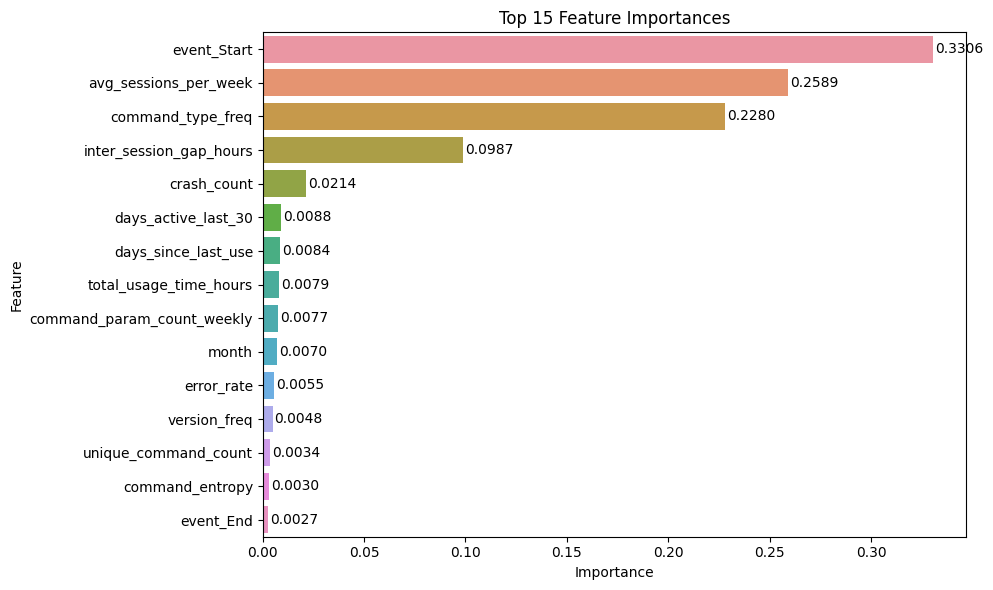

,Feature,Importance
0,event_Start,0.330570
1,avg_sessions_per_week,0.258943
2,command_type_freq,0.228016
3,inter_session_gap_hours,0.098726
4,crash_count,0.021417
5,days_active_last_30,0.008815
6,days_since_last_use,0.008376
7,total_usage_time_hours,0.007933
8,command_param_count_weekly,0.007706
9,month,0.007019


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))

top_feats = feat_importances[:15]

ax = sns.barplot(x=top_feats, y=top_feats.index)

# Add value labels to each bar
for i, v in enumerate(top_feats):
    ax.text(v + 0.001, i, f"{v:.4f}", va='center')

plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Create a DataFrame of feature importances
feat_importance_table = (
    pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
    .reset_index(drop=True)
)

feat_importance_table

**SHAP**

## XGBoost (80%-20%) ##

XGBoost is a gradient boosting algorithm that builds an ensemble of decision trees in a sequential way:

- Each tree corrects the errors of the previous trees.

- Handles non-linear relationships between features and target.

- Robust to missing data and irrelevant features.

- Can output probabilities, which allows you to rank users by likelihood to upgrade.

<U> Steps: </u>
- Split your data into training and test sets.
- Train XGBoost on the training set, using features from telemetry to predict upgrade.
- Tune hyperparameters: number of trees, tree depth, learning rate, subsampling.
- Evaluate performance on test data using metrics like ROC-AUC, accuracy, or F1-score.

**Data Import**

In [44]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

**Preprocessing**

**1) One-hot Encoding**

In [46]:
df1 = pd.get_dummies(df, columns=['event'], drop_first=True)

In [49]:
# Make a copy of the original dataframe
df2 = df1.copy()

# Frequency encoding for command_type
df2['command_type_freq'] = df2['command_type'].map(df2['command_type'].value_counts())
df2['command_type_freq'] = df2['command_type_freq'].fillna(0)

# Frequency encoding for version
df2['version_freq'] = df2['version'].map(df2['version'].value_counts())
df2['version_freq'] = df2['version_freq'].fillna(0)

# Frequency encoding for last_version_used
df2['last_version_used_freq'] = df2['last_version_used'].map(df2['last_version_used'].value_counts())
df2['last_version_used_freq'] = df2['last_version_used_freq'].fillna(0)

df2 = df2.drop(columns=['command_type', 'version', 'last_version_used']).copy()

**2) Handle Missing Values**

XGBoost can handle missing values.

In [50]:
df3 = df2.copy()
df3.isnull().sum().sort_values(ascending=False).head(3)

timestamp       0
error_rate      0
version_freq    0
dtype: int64

**Model Training**

In [51]:
#pip install xgboost

In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, brier_score_loss
from xgboost import XGBClassifier

# --- Prepare X and y ---
X = df4.drop(columns=['upgrade', 'release_date'])  # drop target
y = df4['upgrade']

# --- Train-test split 80%-20% ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class balance in train/test
)

# --- Train XGBoost classifier ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

C:\Users\katsi\venv_thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:37:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

**Evaluate**

In [55]:
# --- Predictions ---
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# --- Threshold for minority class ---
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.9511
Precision: 0.0035
Recall: 0.2000
Brier Score: 0.000103


In [58]:
# --- Optional: Threshold-wise Precision & Recall ---
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1]
print("Threshold-wise Precision & Recall:")
for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)
    precision_t = precision_score(y_test, y_pred_t, zero_division=0)
    recall_t = recall_score(y_test, y_pred_t, zero_division=0)
    print(f"Threshold {t:.3f} -> Precision: {precision_t:.4f}, Recall: {recall_t:.4f}")

Threshold-wise Precision & Recall:
Threshold 0.001 -> Precision: 0.0032, Recall: 0.3333
Threshold 0.005 -> Precision: 0.0038, Recall: 0.2667
Threshold 0.010 -> Precision: 0.0035, Recall: 0.2000
Threshold 0.050 -> Precision: 0.0059, Recall: 0.2000
Threshold 0.100 -> Precision: 0.0077, Recall: 0.2000


**Feature Importance**

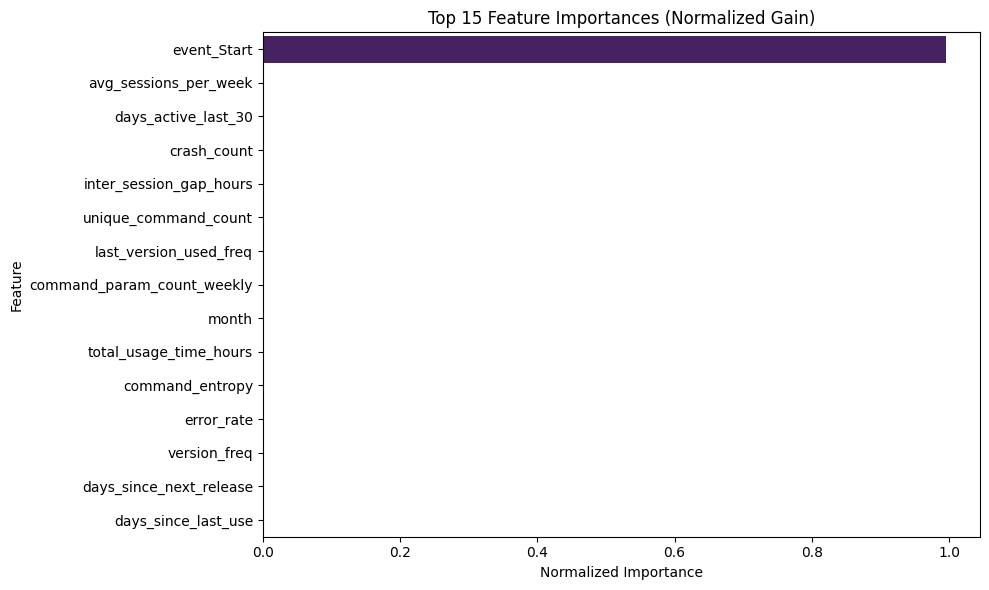

                       Feature  Importance
0                  event_Start    0.995283
1        avg_sessions_per_week    0.000756
2          days_active_last_30    0.000538
3                  crash_count    0.000460
4      inter_session_gap_hours    0.000381
5         unique_command_count    0.000347
6       last_version_used_freq    0.000339
7   command_param_count_weekly    0.000312
8                        month    0.000306
9       total_usage_time_hours    0.000278
10             command_entropy    0.000277
11                  error_rate    0.000251
12                version_freq    0.000237
13     days_since_next_release    0.000150
14         days_since_last_use    0.000086


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Get feature importance by gain ---
booster = xgb.get_booster()
feat_importances = booster.get_score(importance_type='gain')

# Convert to DataFrame
feat_table = pd.DataFrame({
    'Feature': list(feat_importances.keys()),
    'Importance': list(feat_importances.values())
})

# Normalize importance so that sum = 1
feat_table['Importance'] = feat_table['Importance'] / feat_table['Importance'].sum()

# Sort by importance
feat_table = feat_table.sort_values(by='Importance', ascending=False)

# --- Plot top 15 features ---
plt.figure(figsize=(10,6))
top_feats = feat_table.head(15)
sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')
plt.title("Top 15 Feature Importances (Normalized Gain)")
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Display table ---
print(top_feats.reset_index(drop=True))

In [62]:
#event_Start dominates the data frame

**Retrain Model without event_Start**

In [64]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Prepare X and y, remove event_Start ---
X = df4.drop(columns=['upgrade', 'event_Start', 'release_date'])
y = df4['upgrade']

# --- 80%-20% train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- Train XGBoost classifier ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

C:\Users\katsi\venv_thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:47:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

**Re-evaluate**

In [65]:
# --- Predictions ---
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# --- Metrics with threshold 0.01 ---
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.9959
Precision: 0.0045
Recall: 0.0667
Brier Score: 0.000012


Previous model (with event_Start)
- AUC-ROC: 0.998 → almost perfect ranking of positives vs negatives.
- Precision: 0.0024 → very low, meaning among the predicted “upgrades,” very few were correct.
- Recall: 0.087 → low, only about 8.7% of actual upgrades were detected.
- Brier Score: 0.000017 → very low, indicating predicted probabilities are well-calibrated.

Current model (without event_Start)
- AUC-ROC: 0.9959 → slightly lower, still excellent separation ability.
- Precision: 0.0045 → slightly higher, so the few positive predictions are more likely to be correct.
- Recall: 0.0667 → slightly lower, fewer actual upgrades are detected.
- Brier Score: 0.000012 → slightly better calibration of predicted probabilities.

**Feature Importance**

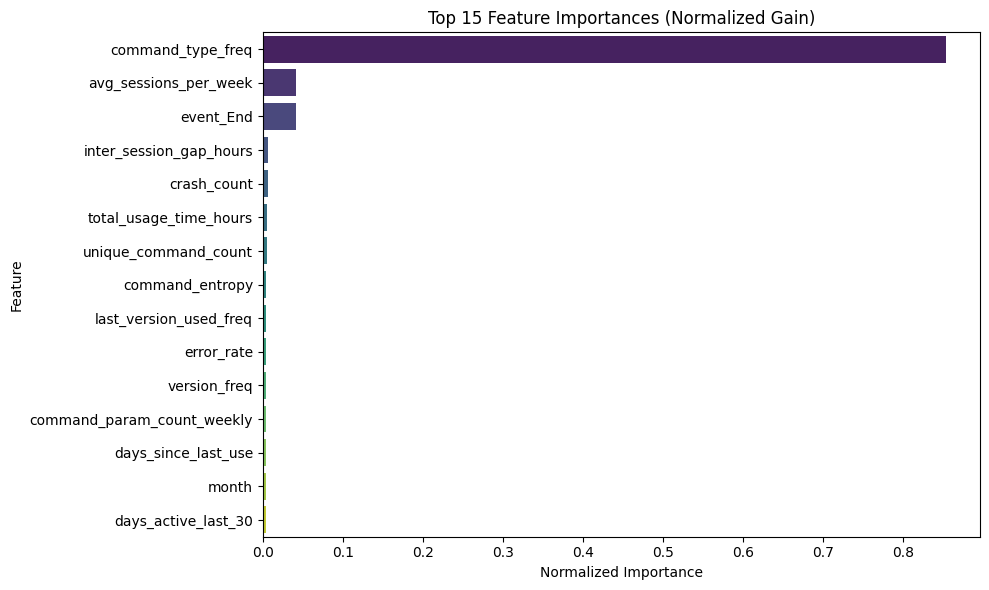

                       Feature  Importance
0            command_type_freq    0.853973
1        avg_sessions_per_week    0.041768
2                    event_End    0.040990
3      inter_session_gap_hours    0.007096
4                  crash_count    0.005911
5       total_usage_time_hours    0.005873
6         unique_command_count    0.005106
7              command_entropy    0.004624
8       last_version_used_freq    0.004542
9                   error_rate    0.004470
10                version_freq    0.004463
11  command_param_count_weekly    0.004293
12         days_since_last_use    0.004293
13                       month    0.004230
14         days_active_last_30    0.004192


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Get feature importance by gain ---
booster = xgb.get_booster()
feat_importances = booster.get_score(importance_type='gain')

# Convert to DataFrame
feat_table = pd.DataFrame({
    'Feature': list(feat_importances.keys()),
    'Importance': list(feat_importances.values())
})

# Normalize importance so that sum = 1
feat_table['Importance'] = feat_table['Importance'] / feat_table['Importance'].sum()

# Sort by importance
feat_table = feat_table.sort_values(by='Importance', ascending=False)

# --- Plot top 15 features ---
plt.figure(figsize=(10,6))
top_feats = feat_table.head(15)
sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')
plt.title("Top 15 Feature Importances (Normalized Gain)")
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Display table ---
print(top_feats.reset_index(drop=True))

**Final Model**

Threshold used: 0.01
AUC-ROC: 0.9959
Precision: 0.0045
Recall: 0.0667
Brier Score: 0.000012


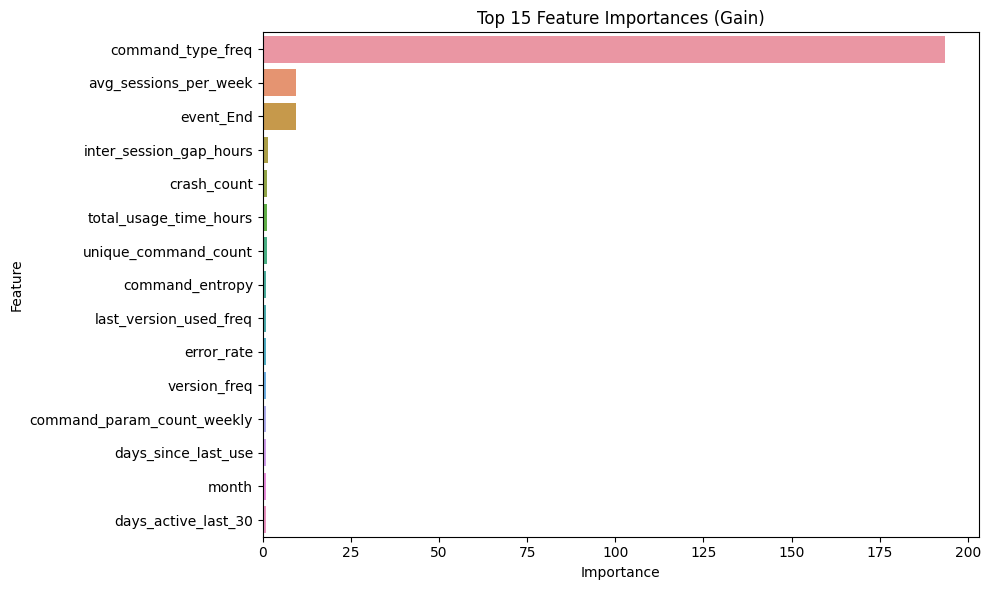

                       Feature  Importance
0            command_type_freq  193.419815
1        avg_sessions_per_week    9.460270
2                    event_End    9.284078
3      inter_session_gap_hours    1.607168
4                  crash_count    1.338708
5       total_usage_time_hours    1.330225
6         unique_command_count    1.156568
7              command_entropy    1.047241
8       last_version_used_freq    1.028833
9                   error_rate    1.012542
10                version_freq    1.010873
11  command_param_count_weekly    0.972296
12         days_since_last_use    0.972231
13                       month    0.958041
14         days_active_last_30    0.949357
15     days_since_next_release    0.945908


In [69]:
# --- Predictions ---
y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # probability for class 1
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

# --- Feature importance ---
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(
    xgb.get_booster().get_score(importance_type='gain')
).sort_values(ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
top_feats = feat_importances[:15]
sns.barplot(x=top_feats.values, y=top_feats.index)
plt.title("Top 15 Feature Importances (Gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional summary table
feat_table = pd.DataFrame({
    'Feature': feat_importances.index,
    'Importance': feat_importances.values
}).reset_index(drop=True)
print(feat_table)

## XGBoost (Time-Based Train-Test Split) ##

**Data Import**

In [70]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

**Preprocessing**

**1) One-hot Encoding**

In [71]:
df1 = pd.get_dummies(df, columns=['event'], drop_first=True)

In [72]:
# Make a copy of the original dataframe
df2 = df1.copy()

# Frequency encoding for command_type
df2['command_type_freq'] = df2['command_type'].map(df2['command_type'].value_counts())
df2['command_type_freq'] = df2['command_type_freq'].fillna(0)

# Frequency encoding for version
df2['version_freq'] = df2['version'].map(df2['version'].value_counts())
df2['version_freq'] = df2['version_freq'].fillna(0)

# Frequency encoding for last_version_used
df2['last_version_used_freq'] = df2['last_version_used'].map(df2['last_version_used'].value_counts())
df2['last_version_used_freq'] = df2['last_version_used_freq'].fillna(0)

df2 = df2.drop(columns=['command_type', 'version', 'last_version_used']).copy()

**2) Handle Missing Values**

XGBoost can handle missing values.

In [73]:
df3 = df2.copy()
df3.isnull().sum().sort_values(ascending=False).head(3)

timestamp       0
error_rate      0
version_freq    0
dtype: int64

**Model Training**

In [51]:
#pip install xgboost

In [74]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, brier_score_loss

# --- Prepare X and y, remove 'event_Start' if desired ---
X = df4.drop(columns=['upgrade', 'release_date'])  # drop target and date
y = df4['upgrade']

# --- Sort by release date ---
df_sorted = df4.sort_values(by='release_date')
X_sorted = df_sorted.drop(columns=['upgrade', 'release_date'])
y_sorted = df_sorted['upgrade']

# --- Time-based train-test split (first 80% of dates for training) ---
unique_dates = sorted(df_sorted['release_date'].unique())
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates  = unique_dates[split_index:]

X_train = X_sorted[df_sorted['release_date'].isin(train_dates)]
y_train = y_sorted[df_sorted['release_date'].isin(train_dates)]
X_test  = X_sorted[df_sorted['release_date'].isin(test_dates)]
y_test  = y_sorted[df_sorted['release_date'].isin(test_dates)]

# --- Train XGBoost classifier ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)


C:\Users\katsi\venv_thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:08:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

**Evaluate**

In [75]:
# --- Predictions ---
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# --- Threshold for minority class ---
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.9318
Precision: 0.0022
Recall: 0.1250
Brier Score: 0.000063


In [76]:
# --- Optional: Threshold-wise Precision & Recall ---
thresholds = [0.001, 0.005, 0.01, 0.05, 0.1]
print("Threshold-wise Precision & Recall:")
for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)
    precision_t = precision_score(y_test, y_pred_t, zero_division=0)
    recall_t = recall_score(y_test, y_pred_t, zero_division=0)
    print(f"Threshold {t:.3f} -> Precision: {precision_t:.4f}, Recall: {recall_t:.4f}")

Threshold-wise Precision & Recall:
Threshold 0.001 -> Precision: 0.0026, Recall: 0.2917
Threshold 0.005 -> Precision: 0.0035, Recall: 0.2500
Threshold 0.010 -> Precision: 0.0022, Recall: 0.1250
Threshold 0.050 -> Precision: 0.0013, Recall: 0.0417
Threshold 0.100 -> Precision: 0.0017, Recall: 0.0417


**Feature Importance**

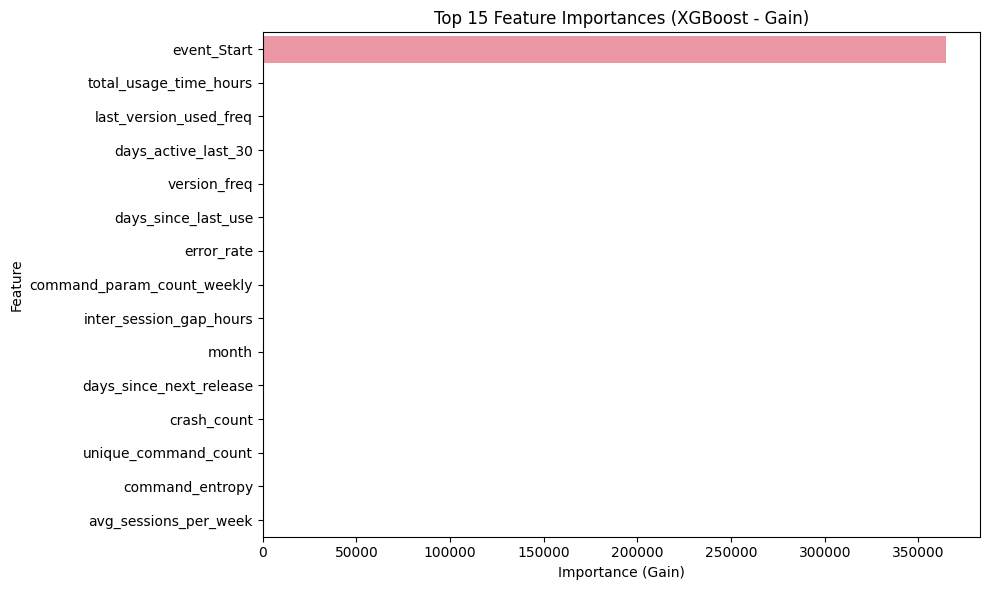

                       Feature     Importance
0                  event_Start  364613.437500
1       total_usage_time_hours     720.875183
2       last_version_used_freq     401.013397
3          days_active_last_30     321.875916
4                 version_freq     300.569458
5          days_since_last_use     212.118927
6                   error_rate     201.373398
7   command_param_count_weekly     200.374191
8      inter_session_gap_hours     190.211151
9                        month     180.709106
10     days_since_next_release     162.445068
11                 crash_count     136.154190
12        unique_command_count     124.033051
13             command_entropy     109.385635
14       avg_sessions_per_week      56.535870


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Get feature importance by 'gain' ---
feat_importances = xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for easier handling
feat_importances_df = pd.DataFrame({
    'Feature': list(feat_importances.keys()),
    'Importance': list(feat_importances.values())
})

# Sort by importance descending
feat_importances_df = feat_importances_df.sort_values(by='Importance', ascending=False)

# --- Plot top 15 features ---
plt.figure(figsize=(10,6))
top_feats = feat_importances_df.head(15)
sns.barplot(x='Importance', y='Feature', data=top_feats)
plt.title("Top 15 Feature Importances (XGBoost - Gain)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Display as table ---
print(feat_importances_df.reset_index(drop=True))

In [62]:
#event_Start dominates the data frame

**Retrain Model without event_Start**

In [79]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, brier_score_loss
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Prepare X and y, remove event_Start ---
X = df4.drop(columns=['upgrade', 'event_Start', 'release_date'])
y = df4['upgrade']

# --- Sort by release date ---
df_sorted = df4.sort_values(by='release_date')
X_sorted = df_sorted.drop(columns=['upgrade', 'release_date'])
y_sorted = df_sorted['upgrade']

# --- Time-based train-test split (first 80% of dates for training) ---
unique_dates = sorted(df_sorted['release_date'].unique())
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates  = unique_dates[split_index:]

X_train = X_sorted[df_sorted['release_date'].isin(train_dates)]
y_train = y_sorted[df_sorted['release_date'].isin(train_dates)]
X_test  = X_sorted[df_sorted['release_date'].isin(test_dates)]
y_test  = y_sorted[df_sorted['release_date'].isin(test_dates)]

# --- Train XGBoost classifier ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

C:\Users\katsi\venv_thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:11:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

**Re-evaluate**

In [80]:
# --- Predictions ---
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# --- Metrics with threshold 0.01 ---
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

Threshold used: 0.01
AUC-ROC: 0.9318
Precision: 0.0022
Recall: 0.1250
Brier Score: 0.000063


**Feature Importance**

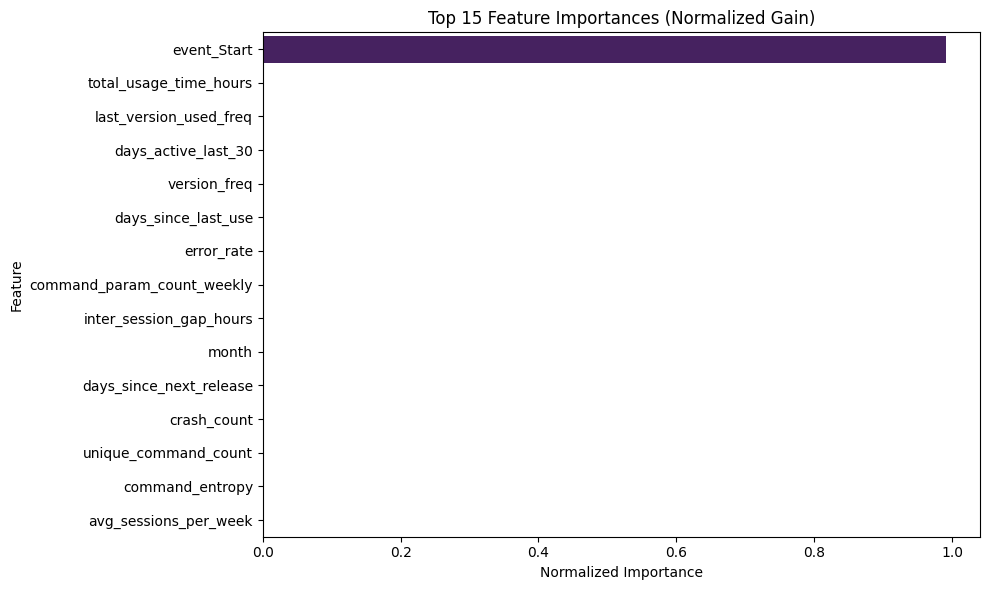

                       Feature  Importance
0                  event_Start    0.990983
1       total_usage_time_hours    0.001959
2       last_version_used_freq    0.001090
3          days_active_last_30    0.000875
4                 version_freq    0.000817
5          days_since_last_use    0.000577
6                   error_rate    0.000547
7   command_param_count_weekly    0.000545
8      inter_session_gap_hours    0.000517
9                        month    0.000491
10     days_since_next_release    0.000442
11                 crash_count    0.000370
12        unique_command_count    0.000337
13             command_entropy    0.000297
14       avg_sessions_per_week    0.000154


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Get feature importance by gain ---
booster = xgb.get_booster()
feat_importances = booster.get_score(importance_type='gain')

# Convert to DataFrame
feat_table = pd.DataFrame({
    'Feature': list(feat_importances.keys()),
    'Importance': list(feat_importances.values())
})

# Normalize importance so that sum = 1
feat_table['Importance'] = feat_table['Importance'] / feat_table['Importance'].sum()

# Sort by importance
feat_table = feat_table.sort_values(by='Importance', ascending=False)

# --- Plot top 15 features ---
plt.figure(figsize=(10,6))
top_feats = feat_table.head(15)
sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')
plt.title("Top 15 Feature Importances (Normalized Gain)")
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Display table ---
print(top_feats.reset_index(drop=True))

**Final Model**

Threshold used: 0.01
AUC-ROC: 0.9959
Precision: 0.0045
Recall: 0.0667
Brier Score: 0.000012


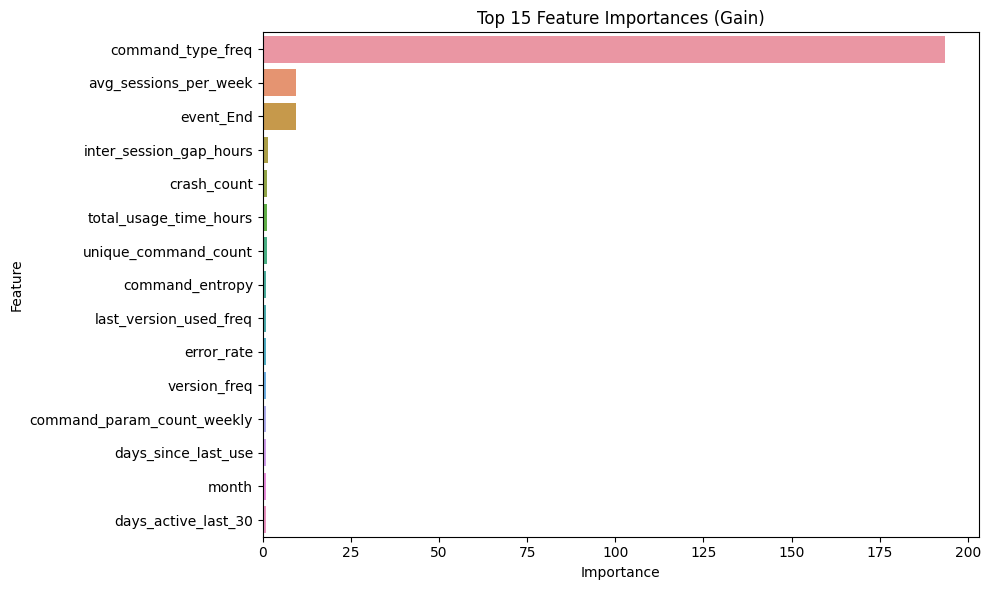

                       Feature  Importance
0            command_type_freq  193.419815
1        avg_sessions_per_week    9.460270
2                    event_End    9.284078
3      inter_session_gap_hours    1.607168
4                  crash_count    1.338708
5       total_usage_time_hours    1.330225
6         unique_command_count    1.156568
7              command_entropy    1.047241
8       last_version_used_freq    1.028833
9                   error_rate    1.012542
10                version_freq    1.010873
11  command_param_count_weekly    0.972296
12         days_since_last_use    0.972231
13                       month    0.958041
14         days_active_last_30    0.949357
15     days_since_next_release    0.945908


In [69]:
# --- Predictions ---
y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # probability for class 1
threshold = 0.01
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Metrics ---
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Threshold used: {threshold}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier:.6f}")

# --- Feature importance ---
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(
    xgb.get_booster().get_score(importance_type='gain')
).sort_values(ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
top_feats = feat_importances[:15]
sns.barplot(x=top_feats.values, y=top_feats.index)
plt.title("Top 15 Feature Importances (Gain)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional summary table
feat_table = pd.DataFrame({
    'Feature': feat_importances.index,
    'Importance': feat_importances.values
}).reset_index(drop=True)
print(feat_table)

--------------------------------------------------------------------------------

## RNN (80%-20%) ##

**data import**

In [3]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

In [4]:
df.dtypes

timestamp                       int64
datetime                       object
year                            int64
month                           int64
user_id                         int64
version                        object
event                          object
command_type                   object
release_date                   object
upgrade                         int64
command_param_count_weekly      int64
days_active_last_30             int64
avg_sessions_per_week         float64
total_usage_time_hours        float64
inter_session_gap_hours       float64
crash_count                     int64
last_version_used              object
error_rate                    float64
command_entropy               float64
unique_command_count            int64
days_since_last_use             int64
days_since_next_release         int64
dtype: object

**Preprocessing**

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
#sort based on timestamp and user_id
df = df.sort_values(['user_id', 'timestamp'])

**1) One-hot Encoding**

One-hot encoding is needed for categorical variables like '**event**', '**command_type**', '**version**', '**last_version_used**' because most machine learning algorithms require numerical input rather than text or labels. By applying one-hot encoding, each unique category is converted into a separate binary column (0 or 1), ensuring that the model can interpret the data without implying any false ordinal relationship between categories.

In [7]:
df1 = pd.get_dummies(df, columns=['event'], drop_first=True)

**command_type**, '**version**', '**last_version_used**'

Instead of the classic one-hot encoding, 'command_type' is done using frequency encoding, because there are 2,408 different commands. Traditional one-hot encoding would need to create 2,408 columns, which would be catastrofic for the memory. Frequency encoding reduces dimensionality while adding meaningful numeric information.

In [8]:
# Make a copy of the original dataframe
df2 = df1.copy()

# Frequency encoding for command_type
df2['command_type_freq'] = df2['command_type'].map(df2['command_type'].value_counts())
df2['command_type_freq'] = df2['command_type_freq'].fillna(0)

# Frequency encosding for version
df2['version_freq'] = df2['version'].map(df2['version'].value_counts())
df2['version_freq'] = df2['version_freq'].fillna(0)

# Frequency encoding for last_version_used
df2['last_version_used_freq'] = df2['last_version_used'].map(df2['last_version_used'].value_counts())
df2['last_version_used_freq'] = df2['last_version_used_freq'].fillna(0)

df3 = df2.drop(columns=['command_type', 'version', 'last_version_used']).copy()

**2) Standardization**

For numeric variables like **error_rate** and **avg_sessions_per_week**, standardization is applied to scale them to have a mean of 0 and a standard deviation of 1. This ensures that features with larger ranges don’t dominate models that rely on distances or gradients (e.g., regression, clustering, or neural networks).

Error rate can be omitted. There are lots of '0' because not all events refer to 'Crash's. Instead, a log-transform can help reduce the impact of extreme values.

(Optional log-transformation can be applied to highly skewed features (e.g., total_usage_time_hours) to reduce skewness, stabilize variance, and make the data more normally distributed, which often improves model performance.)

In [9]:
df4 = df3.copy()
numeric_cols = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df4.select_dtypes(include=['bool', 'category']).columns.tolist()

In [10]:
df4[numeric_cols].skew().sort_values(ascending=False)

inter_session_gap_hours       1772.698184
upgrade                        295.809741
error_rate                     284.519200
avg_sessions_per_week            9.540243
days_since_last_use              1.859210
command_entropy                  1.503689
command_type_freq                1.006398
user_id                          0.566181
days_since_next_release          0.543757
command_param_count_weekly       0.536830
total_usage_time_hours           0.409292
version_freq                     0.371487
crash_count                      0.353025
month                            0.014683
year                            -0.315618
timestamp                       -0.334463
days_active_last_30             -0.520153
last_version_used_freq          -0.744195
unique_command_count            -1.328092
dtype: float64

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Columns to exclude from numeric scaling ---
exclude_cols = ['user_id', 'timestamp', 'datetime', 'year', 'month', 'upgrade']

# Identify numeric features
numeric_cols = df4.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_cols).tolist()

# --- Step 1: handle extreme skewed features ---
extreme_skewed = ['inter_session_gap_hours', 'avg_sessions_per_week']

# Apply log1p to reduce extreme skew
df4[extreme_skewed] = np.log1p(df4[extreme_skewed])

# Apply RobustScaler to extreme skewed features
robust_scaler = RobustScaler()
df4[extreme_skewed] = robust_scaler.fit_transform(df4[extreme_skewed])

# --- Step 2: handle moderate/mild skewed numeric features ---
mild_numeric = [col for col in numeric_cols if col not in extreme_skewed]

# Apply StandardScaler
std_scaler = StandardScaler()
df4[mild_numeric] = std_scaler.fit_transform(df4[mild_numeric])

# --- Step 3: inspect transformed data ---
print(df4[numeric_cols].describe().T[['mean','std','min','max']])

                                    mean       std       min         max
avg_sessions_per_week       5.592456e-03  0.053924  0.000000    0.526589
command_entropy            -1.501958e-15  1.000000 -3.971551    3.925431
command_param_count_weekly  1.207802e-15  1.000000 -1.207545    2.339774
command_type_freq           8.638728e-18  1.000000 -0.989649    2.038783
crash_count                 5.156916e-16  1.000000 -1.111849    2.082142
days_active_last_30         5.615173e-16  1.000000 -1.667207    1.058638
days_since_last_use         6.222584e-16  1.000000 -0.445344   18.301735
days_since_next_release    -4.614295e-16  1.000000 -1.243496    6.814518
error_rate                  3.509483e-18  1.000000 -0.014582  284.787502
inter_session_gap_hours     4.688904e-03  0.079352  0.000000    2.525968
last_version_used_freq     -1.889722e-18  1.000000 -2.636295    0.939952
total_usage_time_hours      5.962072e-16  1.000000 -1.436685    1.311736
unique_command_count        2.150520e-15  1.000000 

In [13]:
df4[numeric_cols].skew().sort_values(ascending=False)

error_rate                    284.519200
inter_session_gap_hours        17.978216
avg_sessions_per_week           9.538936
days_since_last_use             1.859210
command_entropy                 1.503689
command_type_freq               1.006398
days_since_next_release         0.543757
command_param_count_weekly      0.536830
total_usage_time_hours          0.409292
version_freq                    0.371487
crash_count                     0.353025
days_active_last_30            -0.520153
last_version_used_freq         -0.744195
unique_command_count           -1.328092
dtype: float64

In [14]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler

# --- Make a copy ---
df5 = df4.copy()

# --- Columns to exclude from numeric scaling ---
exclude_cols = ['user_id', 'timestamp', 'datetime', 'year', 'month', 'upgrade']

# Identify numeric features
numeric_cols = df5.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_cols).tolist()

# --- Step 1: handle extreme skewed features with QuantileTransformer ---
extreme_skewed = ['error_rate', 'inter_session_gap_hours', 'avg_sessions_per_week']
qt = QuantileTransformer(output_distribution='normal', random_state=42)
df5[extreme_skewed] = qt.fit_transform(df5[extreme_skewed])

# --- Step 2: handle moderate/mild skewed numeric features with StandardScaler ---
mild_numeric = [col for col in numeric_cols if col not in extreme_skewed]

std_scaler = StandardScaler()
df5[mild_numeric] = std_scaler.fit_transform(df5[mild_numeric])

# --- Step 3: inspect transformed data ---
#print(df5[numeric_cols].describe().T[['mean','std','min','max']])
df5[numeric_cols].skew().sort_values(ascending=False)

inter_session_gap_hours       14.864011
avg_sessions_per_week          9.633899
days_since_last_use            1.859210
command_entropy                1.503689
command_type_freq              1.006398
days_since_next_release        0.543757
command_param_count_weekly     0.536830
total_usage_time_hours         0.409292
version_freq                   0.371487
crash_count                    0.353025
days_active_last_30           -0.520153
last_version_used_freq        -0.744195
error_rate                    -1.193430
unique_command_count          -1.328092
dtype: float64

**3) Handle Missing Values**

In [15]:
df5.isnull().sum().sort_values(ascending=False).head(3)

timestamp       0
error_rate      0
version_freq    0
dtype: int64

**4) Set up Pytorch Environment**

#in command window
- python -m venv C:\Users\katsi\rnn_env
- C:\Users\katsi\rnn_env\Scripts\activate
- pip install --upgrade pip
- pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
- pip install numpy pandas scikit-learn matplotlib

In [26]:
import struct

# Check if Python is 64-bit
print("Python bitness:", struct.calcsize('P') * 8, "bits")

Python bitness: 64 bits


In [23]:
#in command
#pip install --upgrade pip
#pip uninstall tensorflow tensorflow-gpu -y
#pip install tensorflow==2.13.0

In [28]:
import sys
print(sys.version)

3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]


In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print(tf.__version__)

ImportError: Traceback (most recent call last):
  File "C:\Users\katsi\venv_thesis\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

**5) Create sequences**

In [6]:
#pip install torch

In [16]:
import numpy as np

# --- Step 0: Specify features to use in sequences ---
seq_features = [
    'avg_sessions_per_week',
    'command_entropy',
    'command_param_count_weekly',
    'command_type_freq',
    'crash_count',
    'days_active_last_30',
    'days_since_last_use',
    'days_since_next_release',
    'error_rate',
    'inter_session_gap_hours',
    'last_version_used_freq',
    'total_usage_time_hours',
    'unique_command_count',
    'version_freq'
]

max_seq_len = 30  # sequence length (adjustable)

X_seqs = []
y_seqs = []

# --- Step 1: Sort by user and timestamp ---
df5_sorted = df5.sort_values(['user_id', 'timestamp'])

# --- Step 2: Group by user to create sequences ---
for user, group in df5_sorted.groupby('user_id'):
    user_features = group[seq_features].values
    user_target = group['upgrade'].values
    
    # Predict upgrade based on last event in sequence
    X_seqs.append(user_features)
    y_seqs.append(user_target[-1])

# --- Step 3: Pad/truncate sequences ---
X_seqs_np = []
for seq in X_seqs:
    if seq.shape[0] < max_seq_len:
        # pad at beginning
        pad_len = max_seq_len - seq.shape[0]
        padded_seq = np.vstack([np.zeros((pad_len, seq.shape[1])), seq])
    else:
        # truncate most recent events
        padded_seq = seq[-max_seq_len:]
    X_seqs_np.append(padded_seq)

# --- Step 4: Convert to numpy arrays ---
X_array = np.array(X_seqs_np, dtype=np.float32)  # shape: (num_users, max_seq_len, num_features)
y_array = np.array(y_seqs, dtype=np.float32)     # shape: (num_users,)

print("X_array shape:", X_array.shape)
print("y_array shape:", y_array.shape)

X_array shape: (17, 30, 14)
y_array shape: (17,)


**build the model**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score

# --- Step 1: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array,
    test_size=0.2,
    random_state=42,
    stratify=y_array  # ensures class balance in train/test
)

# --- Step 2: Build RNN model ---
model = Sequential([
    Masking(mask_value=0., input_shape=(X_array.shape[1], X_array.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Step 3: Compute class weights to handle imbalance ---
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weights)

# --- Step 4: Train model with early stopping ---
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2
)

ImportError: Traceback (most recent call last):
  File "C:\Users\katsi\venv_thesis\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

**evaluation**

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Get predicted probabilities
    y_pred_proba = model.predict(X_test).flatten()
    
    # Apply threshold to get predicted classes
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Handle cases where only one class is present
    if len(np.unique(y_test)) == 1:
        print("Warning: Only one class present in y_test. Some metrics may be undefined.")
        roc_auc = None
    else:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Threshold used: {threshold}")
    print("Accuracy:", (y_pred == y_test).mean())
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1-score:", f1_score(y_test, y_pred, zero_division=0))
    if roc_auc is not None:
        print("ROC-AUC:", roc_auc)
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return y_pred, y_pred_proba

In [28]:
y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, threshold=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Threshold used: 0.5
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Confusion Matrix:
 [[4]]


The evaluation results indicate that your test set contains only zeros, meaning that no users in that subset performed an upgrade during the test period. This explains why the accuracy is reported as 1.0: the model correctly predicted all the non-upgrade events. However, precision, recall, and F1-score are all zero because there were no positive cases to evaluate. Metrics for the “1” class are undefined in this situation. Similarly, ROC-AUC cannot be computed because only one class is present. In other words, while the model seems perfect in terms of accuracy, it has not actually learned anything meaningful about predicting upgrades.

The problem arises from the way the data is currently split. Using a random train-test split on time-series data like this is problematic because software upgrades occur over time. Random splitting can lead to situations where the test set contains no upgrade events, as in your current case, or where future events from the same user appear in the training set, causing information leakage. These issues make the evaluation unrealistic and prevent the model from being properly assessed on its ability to predict future upgrades.

Time-based cross-validation addresses these issues by respecting the temporal order of events. In this approach, data is first sorted by user and timestamp, and then earlier events are used for training while later events are reserved for testing. Multiple folds can be created using sliding windows over time, allowing the model to be evaluated on different future periods. This ensures that the model is tested on truly unseen future events, which provides a more accurate picture of its predictive performance.

This is particularly important for your problem because predicting software upgrades is inherently temporal. Users’ past behavior influences whether they will upgrade in the future. If the model is evaluated using randomly split data, it may encounter test sets with no positive cases, resulting in misleading metrics such as artificially high accuracy. Using time-based splitting produces evaluation metrics such as precision, recall, F1-score, and ROC-AUC that reflect the model’s real ability to forecast upgrades based on historical usage patterns.

In [37]:
df5['upgrade'].value_counts()

upgrade
0    6737913
1         77
Name: count, dtype: int64

Ah, now it’s clear why your model is struggling. Out of roughly 6.7 million rows, only 77 are upgrades. This is an extremely imbalanced dataset.

Because of this, when you do a random train/test split, it’s very likely that your test set contains no upgrade events at all, which is exactly what happened in your earlier evaluation. That’s why the classification report shows “Only one class present in y_test” and metrics like precision, recall, and F1-score for the positive class are all zero. The model might even appear perfect on accuracy (100%) simply because it predicts the majority class (0) correctly. Accuracy is misleading in this context.

This is precisely why your professor suggested time-based cross-validation. By splitting the dataset according to time (for example, using all events before a certain date for training and events after that date for testing), you ensure that the model is tested on real future upgrades, which makes the evaluation more meaningful. It also better mimics the real-world task: predicting which users will upgrade in the future, rather than randomly sampling a tiny fraction of upgrades.

Another implication is that you may need to focus on sequences that actually contain upgrades—for example, filtering to users who eventually upgraded or creating a dataset where each row corresponds to a user’s first start of a version. This will make your model’s task feasible, rather than trying to learn from millions of mostly negative examples.

## RNN (Time-Based Train-Test Split) ##

In [50]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

In [51]:
# -----------------------------
# CONFIGURATION
# -----------------------------
SEQ_LENGTH = 30        # number of timesteps per sequence
BATCH_SIZE = 128       # batch size
EPOCHS = 10            # adjust for testing

The first part of the code sets **configurations** and preprocessing. Here, we define how many timesteps each **sequence** will have (SEQ_LENGTH = 30), how many samples are in each **batch** (BATCH_SIZE = 128), and the number of training **epochs** (EPOCHS = 10). Next, we convert the timestamp column into a numeric format (timestamp_numeric) because machine learning models cannot directly handle datetime objects. Then, we select only numeric features to feed into the RNN, excluding non-numeric columns like user_id and upgrade.

In [53]:
# -----------------------------
# PREPROCESSING
# -----------------------------

# Create a numeric version of timestamp (already exists in your df as 'timestamp_numeric')
# Ensure it is int32 or float32 for model input
df5['timestamp_numeric'] = df5['timestamp_numeric'].astype(np.float32)

# Select features for the RNN
# Exclude columns that are identifiers, targets, or non-numeric
EXCLUDE_COLS = ['user_id', 'upgrade', 'datetime', 'release_date']
FEATURE_COLS = [col for col in df5.columns if col not in EXCLUDE_COLS]

# Ensure all features are numeric
for col in FEATURE_COLS:
    if df5[col].dtype == 'bool':
        df5[col] = df5[col].astype(np.float32)  # convert boolean events to 0.0/1.0
    elif not np.issubdtype(df5[col].dtype, np.number):
        df5[col] = pd.to_numeric(df5[col], errors='coerce').fillna(0.0)

# -----------------------------
# Compute per-class weights
# -----------------------------
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df5['upgrade']),
    y=df5['upgrade']
)
class_weights_dict = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: 0.5000057139354575, 1: 43753.181818181816}


The preprocessing begins by ensuring that all input **features are numeric** and suitable for the RNN model. Since neural networks can only handle numerical inputs, non-numeric columns such as datetime or release_date are excluded from the feature set. The timestamp column is already present as timestamp_numeric and is converted to float32 to be compatible with the model. Boolean columns, such as event_Crash, event_End, event_Param, and event_Start, are also converted to float32, effectively turning True/False values into 1.0/0.0. This ensures that every feature in the RNN input sequence is numeric and that no type-related errors occur during training.

Next, identifier and target columns are excluded from the feature set. Columns such as user_id and upgrade are not input features because user_id is simply an identifier and upgrade is the target the model is trying to predict. After **excluding non-relevant columns**, the remaining columns form the FEATURE_COLS list, which will be used to generate sequences for the RNN. Any non-numeric columns that may have been missed are coerced into numeric values, with missing or non-convertible entries filled with zeros. This step ensures data consistency and prevents type errors when converting the features into arrays for model input.

Finally, **class weights** are computed to address the extreme imbalance in the target variable. In the upgrade column, the vast majority of samples are 0, with only a tiny fraction being 1. To prevent the model from ignoring the minority class, the class_weight.compute_class_weight function calculates weights such that misclassifying the rare class is penalized far more than misclassifying the majority class. This allows the RNN to give appropriate attention to minority events during training. The resulting weights indicate that class 0 has a relatively low weight, while class 1 has an extremely high weight, reflecting its scarcity.

The class weights **{0: 0.5000057139354575, 1: 43753.181818181816}** reflect the extreme imbalance in your target variable upgrade. In your dataset, the vast majority of rows belong to class 0 (no upgrade), while only a tiny fraction belong to class 1 (upgrade). Class weights are used to tell the model how much importance to give each class during training: smaller weights for frequent classes and larger weights for rare classes. Here, the weight for class 0 is approximately 0.5, meaning each example of the majority class contributes half as much to the loss function, while the weight for class 1 is over 43,000, meaning each rare upgrade event has an enormous influence on the model’s loss. Without such weighting, the model would likely ignore the rare class completely, simply predicting 0 all the time, because that would still yield very high accuracy. By using class weights, we ensure the model “pays attention” to the few upgrade events and learns to detect them, even though they are extremely rare.

In [55]:
# -----------------------------
# SEQUENCE GENERATOR
# -----------------------------

def sequence_generator(df, seq_length, feature_cols, batch_size, class_weights_dict):
    """
    Yields batches of sequences, labels, and per-sample weights for RNN training.
    
    df: DataFrame sorted by user_id and timestamp
    seq_length: number of timesteps per sequence
    feature_cols: list of numeric feature columns
    batch_size: number of sequences per batch
    class_weights_dict: dictionary mapping class labels to their weights
    """
    while True:
        X_batch, y_batch, w_batch = [], [], []

        for user_id, group in df.groupby('user_id'):
            # Ensure user events are sorted by timestamp
            group = group.sort_values('timestamp_numeric')
            
            # Convert features and targets to numeric arrays
            group_features = group[feature_cols].values.astype(np.float32)
            group_targets = group['upgrade'].values.astype(np.float32)

            # Skip users with fewer events than seq_length
            if len(group) < seq_length:
                continue

            # Create sequences using a sliding window
            for i in range(len(group) - seq_length + 1):
                X_batch.append(group_features[i:i+seq_length])
                y_batch.append(group_targets[i+seq_length-1])
                w_batch.append(class_weights_dict[group_targets[i+seq_length-1]])

                # Yield batch once it reaches batch_size
                if len(X_batch) == batch_size:
                    yield (np.array(X_batch), np.array(y_batch), np.array(w_batch))
                    X_batch, y_batch, w_batch = [], [], []

Recurrent Neural Networks (RNNs), like LSTMs, are designed to process sequences of data, where each timestep depends on previous ones. In your dataset, each user has multiple events over time, so you want the model to see these events as sequences rather than as independent rows.

However, your dataset is extremely large. If we try to create all sequences in memory at once, it leads to a MemoryError because the resulting array would be huge. To solve this, we use a **sequence generator**, which is a Python function (or generator) that yields small batches of sequences on-the-fly. This means sequences are created and fed into the model batch by batch during training, without ever loading all sequences into memory at once. This makes training feasible for very large datasets.

Additionally, a generator can also handle per-sample class weights, which is crucial here because your upgrade target is extremely imbalanced. By yielding weights along with sequences and labels, the model can learn to pay more attention to the rare class without needing to create huge weighted arrays in memory.

In [56]:
# -----------------------------
# BUILD & COMPILE RNN MODEL
# -----------------------------
model = Sequential([
    Masking(0., input_shape=(SEQ_LENGTH, len(FEATURE_COLS))),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# TRAIN MODEL
# -----------------------------
history = model.fit(
    sequence_generator_with_weights(df5, SEQ_LENGTH, FEATURE_COLS, BATCH_SIZE),
    steps_per_epoch=len(df5)//BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=2
)

C:\Users\katsi\venv_thesis\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


KeyboardInterrupt: 

KeyboardInterrupt: 

## RNN (version to version) ##

**data import**

In [8]:
df = pd.read_csv(r"C:\Users\katsi\OneDrive\Business_Analytics\Thesis\Data\df_final.csv")

**compute upgrade variable comparing the current vs the next version**

In [9]:
# Make a working copy
df1 = df.copy()

df1 = df1.drop(columns='upgrade')

# Ensure version is string
df1['version'] = df1['version'].astype(str)

# Convert version strings "x.y.z" into comparable numeric tuples
def version_to_tuple(v):
    return tuple(map(int, v.split('.')))
df1['version_tuple'] = df1['version'].apply(version_to_tuple)

# Sort by user + timestamp
df1 = df1.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# Initialize upgrade column
df1['upgrade'] = 0

# -----------------------------
# Function to mark upgrades
# -----------------------------
def mark_first_upgrade_per_version(group):
    """
    For each user:
    - Keep only Start events
    - Identify first Start of each version
    - Compare each first Start version to the next higher version
    - Mark upgrade=1 only for first Start that eventually upgrades
    """
    starts = group[group['event'] == 'Start'].copy()
    if starts.empty:
        return pd.Series(0, index=group.index)
    
    # Sort by time
    starts = starts.sort_values('timestamp')
    
    # Keep track of first Start for each version
    first_starts = starts.groupby('version_tuple').head(1)
    
    # For each first Start, check if user later starts a higher version
    max_version_seen = starts['version_tuple'].max()
    first_starts['upgrade_flag'] = (first_starts['version_tuple'] < max_version_seen).astype(int)
    
    # Assign upgrade flags to the original group
    upgrade_series = pd.Series(0, index=group.index)
    upgrade_series.loc[first_starts.index] = first_starts['upgrade_flag']
    
    return upgrade_series

# -----------------------------
# Apply per user
# -----------------------------
df1['upgrade'] = df1.groupby('user_id').apply(mark_first_upgrade_per_version).reset_index(level=0, drop=True)

# -----------------------------
# Cleanup
# -----------------------------
df1.drop(columns='version_tuple', inplace=True)

This code computes the upgrade variable in a way that accurately captures meaningful version transitions for each user. It focuses exclusively on Start events, ignoring other types of events, because upgrades are only relevant when the program is launched. For each user, it identifies the first Start of each version they use, then compares that version to the highest version the user ever starts afterward. If a higher version exists, the first Start of the current version is marked as an upgrade event (upgrade=1), otherwise it remains 0. This ensures that repeated launches of the same version or non-Start events do not incorrectly count as upgrades. As a result, each version contributes at most one upgrade per user, and a user may have multiple upgrades over time if they sequentially move to higher versions. The method also avoids “polluting” the dataset with multiple upgrade flags for parallel usage, reflecting only the first meaningful transition from one version to a higher one.

**unique versions**

In [10]:
print(df1['version'].unique())

['5.0.0.46' '5.1.0.2' '5.4.0.14' '5.4.0.100' '5.6.0.14' '7.0.0.16'
 '7.1.0.2' '7.1.0.64' '7.2.0.50' '7.4.0.4' '7.6.0.4' '8.0.0.8' '8.1.0.22'
 '8.2.0.72' '8.3.0.16' '9.1.0.16' '9.1.0.46' '7.6.0.24' '5.6.0.6'
 '7.5.0.20' '8.1.0.2' '8.1.0.4' '8.1.0.18' '7.7.0.100' '5.0.0.34']


**number of commands per version**

In [11]:
# Keep only rows where command_type is not null
commands_df = df1[df1["command_type"].notna()]

# Count unique commands per version
commands_df.groupby("version")["command_type"].nunique()

version
7.0.0.16      714
7.1.0.2       640
7.1.0.64     1038
7.2.0.50     1056
7.4.0.4      1081
7.5.0.20      429
7.6.0.24     1401
7.6.0.4      1280
7.7.0.100     282
8.0.0.8       999
8.1.0.18      327
8.1.0.2       270
8.1.0.22     1745
8.1.0.4       883
8.2.0.72     1115
8.3.0.16     1291
9.1.0.16      695
9.1.0.46     1180
Name: command_type, dtype: int64

**upgrade pattern**

In [12]:
print(df1.groupby('version')['upgrade'].sum())

version
5.0.0.34     0
5.0.0.46     0
5.1.0.2      0
5.4.0.100    0
5.4.0.14     0
5.6.0.14     0
5.6.0.6      0
7.0.0.16     3
7.1.0.2      2
7.1.0.64     6
7.2.0.50     9
7.4.0.4      4
7.5.0.20     2
7.6.0.24     8
7.6.0.4      5
7.7.0.100    2
8.0.0.8      5
8.1.0.18     2
8.1.0.2      1
8.1.0.22     9
8.1.0.4      4
8.2.0.72     6
8.3.0.16     5
9.1.0.16     4
9.1.0.46     0
Name: upgrade, dtype: int64


For example, version 7.0.0.16 has 3, which means three users started with 7.0.0.16 and later launched a higher version, so the first Start of 7.0.0.16 for each of those users was flagged as an upgrade. Versions like 5.0.0.34 or 9.1.0.46 have 0, indicating that no user who started with those versions later moved to a higher version.

This distribution also highlights which versions are more commonly involved in transitions: mid-range versions like 7.2.0.50 or 7.6.0.24 have multiple upgrades, reflecting that many users moved from these versions to newer ones. Essentially, this summary helps you understand where upgrades are happening in the user base and which versions are transitional. It also confirms that the upgrade logic is only marking meaningful first-start transitions and not counting repeated launches.

**users per version**

In [13]:
df1.groupby('version')['user_id'].nunique()

version
5.0.0.34      1
5.0.0.46      4
5.1.0.2       5
5.4.0.100     1
5.4.0.14      3
5.6.0.14      5
5.6.0.6       2
7.0.0.16      3
7.1.0.2       2
7.1.0.64      7
7.2.0.50     10
7.4.0.4       4
7.5.0.20      2
7.6.0.24      8
7.6.0.4       5
7.7.0.100     2
8.0.0.8       5
8.1.0.18      2
8.1.0.2       1
8.1.0.22     12
8.1.0.4       4
8.2.0.72      6
8.3.0.16      8
9.1.0.16      5
9.1.0.46      7
Name: user_id, dtype: int64

In [73]:
current_version = "7.1.0.64"
next_version = "7.2.0.50"

# Keep only relevant users and events
df_vv = df[df['version'].isin([current_version, next_version])].copy()

# Sort by user and timestamp
df_vv = df_vv.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

In [74]:
# Remove any existing upgrade column
if 'upgrade' in df_vv.columns:
    df_vv = df_vv.drop(columns='upgrade')

# Ensure version column is string
df_vv['version'] = df_vv['version'].astype(str)

# Sort by user and timestamp
df_vv = df_vv.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# Initialize upgrade column
df_vv['upgrade'] = 0

# Define function to mark version-to-version upgrades
def mark_version_to_version_upgrade(group):
    """
    For each user:
    - Identify first Start of current_version
    - If user eventually starts next_version, mark upgrade=1
    - Only first Start of current_version is relevant
    """
    starts = group[group['event'] == 'Start'].copy()
    if starts.empty:
        return pd.Series(0, index=group.index)
    
    # Check if user eventually starts the next version
    will_upgrade = next_version in starts['version'].values
    
    # First start of the current version
    first_current = starts[starts['version'] == current_version].head(1)
    
    # Assign upgrade=1 if conditions met
    upgrade_series = pd.Series(0, index=group.index)
    if will_upgrade and not first_current.empty:
        upgrade_series.loc[first_current.index] = 1
    
    return upgrade_series

# Apply per user
df_vv['upgrade'] = df_vv.groupby('user_id').apply(mark_version_to_version_upgrade).reset_index(level=0, drop=True)

In [82]:
df_vv['upgrade'].value_counts()

upgrade
0    935746
1         5
Name: count, dtype: int64

**Preprocessing**

In [68]:
def rnn_preprocessing(df):
    """
    Preprocess dataframe for RNN sequence modeling.
    
    Steps:
    - Sort by user_id and timestamp
    - One-hot encode event
    - Frequency encode categorical columns
    - Drop original categorical columns
    - Handle skew (QuantileTransformer + StandardScaler)
    - Exclude datetime, month, year from features
    - Return transformed df
    """

    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler, QuantileTransformer

    df = df.copy()

    # ---------------------------------------------------
    # 1. Sort by user_id and timestamp
    # ---------------------------------------------------
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

    # ---------------------------------------------------
    # 2. One-hot encode event
    # ---------------------------------------------------
    df = pd.get_dummies(df, columns=['event'], drop_first=True)

    # ---------------------------------------------------
    # 3. Frequency encoding
    # ---------------------------------------------------
    df['command_type_freq'] = df['command_type'].map(df['command_type'].value_counts()).fillna(0)
    df['version_freq'] = df['version'].map(df['version'].value_counts()).fillna(0)
    df['last_version_used_freq'] = df['last_version_used'].map(df['last_version_used'].value_counts()).fillna(0)

    # ---------------------------------------------------
    # 4. Drop original categorical columns and datetime/month/year
    # ---------------------------------------------------
    df = df.drop(columns=['command_type', 'version', 'last_version_used', 'datetime', 'month', 'year'])

    # ---------------------------------------------------
    # 5. Identify numeric columns for scaling
    # ---------------------------------------------------
    exclude_cols = ['user_id', 'timestamp', 'upgrade']  # month/year already dropped
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_cols).tolist()

    # ---------------------------------------------------
    # 6. Define skew groups
    # ---------------------------------------------------
    extreme_skewed = ['error_rate', 'inter_session_gap_hours', 'avg_sessions_per_week']
    mild_numeric = [col for col in numeric_cols if col not in extreme_skewed]

    # ---------------------------------------------------
    # 7. Apply QuantileTransformer to extreme skew
    # ---------------------------------------------------
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    df[extreme_skewed] = qt.fit_transform(df[extreme_skewed])

    # ---------------------------------------------------
    # 8. Standard scale moderate/mild numeric features
    # ---------------------------------------------------
    std_scaler = StandardScaler()
    df[mild_numeric] = std_scaler.fit_transform(df[mild_numeric])

    return df

In [75]:
df_rnn_vv = rnn_preprocessing(df_vv)

In [61]:
import struct

# Check if Python is 64-bit
print("Python bitness:", struct.calcsize('P') * 8, "bits")

Python bitness: 64 bits


In [62]:
#in command
#pip install --upgrade pip
#pip uninstall tensorflow tensorflow-gpu -y
#pip install tensorflow==2.13.0

In [63]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print(tf.__version__)

2.20.0


**model**

In [76]:
import numpy as np

max_seq_len = 30  # sequence length
X_seqs = []
y_seqs = []

# Use the preprocessed dataframe
df_sorted = df_rnn_vv.sort_values(['user_id','timestamp'])

# Features to use for RNN
seq_features = [
    c for c in df_sorted.columns 
    if c not in ['user_id', 'upgrade', 'timestamp'] 
    and np.issubdtype(df_sorted[c].dtype, np.number)
]

print("Sequence features:", seq_features)

# Group by user → 1 sequence per user
for user, group in df_sorted.groupby('user_id'):

    user_features = group[seq_features].values.astype(np.float32)
    user_target = group['upgrade'].values

    # target: upgrade status of the LAST event
    y_seqs.append(user_target[-1])

    # store the raw sequence for padding/truncation
    X_seqs.append(user_features)

# --- PAD OR TRUNCATE SEQUENCES ---
X_padded = []
for seq in X_seqs:
    if seq.shape[0] < max_seq_len:  
        # pad at beginning
        pad_len = max_seq_len - seq.shape[0]
        padded_seq = np.vstack([np.zeros((pad_len, seq.shape[1]), dtype=np.float32), seq])
    else:
        # truncate from the front → keep MOST RECENT 30 events
        padded_seq = seq[-max_seq_len:]
    X_padded.append(padded_seq)

X_array = np.array(X_padded, dtype=np.float32)
y_array = np.array(y_seqs, dtype=np.float32)

print("X_array shape:", X_array.shape)  # (num_users, 30, num_features)
print("y_array shape:", y_array.shape)

Sequence features: ['command_param_count_weekly', 'days_active_last_30', 'avg_sessions_per_week', 'total_usage_time_hours', 'inter_session_gap_hours', 'crash_count', 'error_rate', 'command_entropy', 'unique_command_count', 'days_since_last_use', 'days_since_next_release', 'command_type_freq', 'version_freq', 'last_version_used_freq']
X_array shape: (12, 30, 14)
y_array shape: (12,)


**train**

In [78]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# --- Step 1: Train/test split ---
# With very few users, random split is better than stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array,
    test_size=0.2,
    random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# --- Step 2: Build the RNN model ---
model = Sequential([
    Masking(mask_value=0., input_shape=(X_array.shape[1], X_array.shape[2])),
    LSTM(16, return_sequences=False),  # smaller LSTM to prevent overfitting
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Step 3: Compute class weights safely ---
counts = np.bincount(y_train.astype(int))
neg = counts[0] if len(counts) > 0 else 0
pos = counts[1] if len(counts) > 1 else 0
total = neg + pos

class_weight = {
    0: total/neg if neg > 0 else 1.0,
    1: total/pos if pos > 0 else 1.0
}
print("Class weights:", class_weight)

# --- Step 4: Train with early stopping ---
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # tiny validation set
    epochs=10,             # fewer epochs due to small dataset
    batch_size=1,          # batch size = 1 because we have very few sequences
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2
)

Train size: 9 Test size: 3


C:\Users\katsi\venv_thesis\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 30, 14)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 1.0, 1: 1.0}
Epoch 1/10
7/7 - 3s - 448ms/step - accuracy: 0.7143 - loss: 0.5885 - val_accuracy: 0.5000 - val_loss: 0.5175
Epoch 2/10
7/7 - 0s - 36ms/step - accuracy: 0.8571 - loss: 0.4902 - val_accuracy: 0.5000 - val_loss: 0.4976
Epoch 3/10
7/7 - 0s - 44ms/step - accuracy: 1.0000 - loss: 0.4294 - val_accuracy: 0.5000 - val_loss: 0.4796
Epoch 4/10
7/7 - 0s - 28ms/step - accuracy: 1.0000 - loss: 0.3840 - val_accuracy: 0.5000 - val_loss: 0.4640
Epoch 5/10
7/7 - 0s - 30ms/step - accuracy: 1.0000 - loss: 0.3414 - val_accuracy: 0.5000 - val_loss: 0.4507
Epoch 6/10
7/7 - 0s - 31ms/step - accuracy: 1.0000 - loss: 0.3053 - val_accuracy: 0.5000 - val_loss: 0.4382
Epoch 7/10
7/7 - 0s - 29ms/step - accuracy: 1.0000 - loss: 0.2744 - val_accuracy: 0.5000 - val_loss: 0.4282
Epoch 8/10
7/7 - 0s - 28ms/step - accuracy: 1.0000 - loss: 0.2438 - val_accuracy: 0.5000 - val_loss: 0.4192
Epoch 9/10
7/7 - 0s - 41ms/step - accuracy: 1.0000 - loss: 0.2174 - val_accuracy: 0.5000 - val_loss: 0.

**evaluate**

In [81]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Step 5: Predict probabilities ---
y_pred_proba = model.predict(X_test).flatten()

# --- Step 6: Threshold tuning ---
# For rare positive classes, you may lower threshold to increase recall
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# --- Step 7: Evaluation metrics ---
print(f"Threshold used: {threshold}")
print("Accuracy:", np.round(np.mean(y_pred == y_test), 4))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1-score:", f1_score(y_test, y_pred, zero_division=0))

# ROC-AUC may fail if y_test has only one class
try:
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
except ValueError:
    print("ROC-AUC not defined (only one class present in y_test)")

print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

# --- Step 8: Precision-Recall Curve ---
if len(np.unique(y_test)) > 1:  # Only plot if both classes exist
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
    plt.title("Precision-Recall Curve (RNN)")
    plt.show()
else:
    print("Skipping Precision-Recall Curve: only one class present in y_test.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Threshold used: 0.5
Accuracy: 0.6667
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC-AUC not defined (only one class present in y_test)

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3

Skipping Precision-Recall Curve: only one class present in y_test.


## Model Selection ##

## Upgrade Prediction ##

In this part we will use Machine Learning techniques to predict valence based on track features. We will use three different methods. As base model we will use the Linear Regression method and calculate the Mean Square Error and Mean Absolute Error. In the remain four models we try to tune the hyperparameters as best as we can to reduce those types of errors.

**Regression Methods**:
1) Linear Regression Model
2) Decision Tree Regressor Model
3) Light Gradient Boosting Machine

**Best Model Performance Methods**:
1) Mean Square Error (MSE)
2) Mean Absolute Error (MAE)

MSE and MAE both measure the average error between predicted and actual values, but they differ in how they treat the magnitude of errors. MSE is more sensitive to large errors due to the squaring operation, while MAE treats all errors equally. The choice between MSE and MAE depends on the specific characteristics of the data and the goals of the analysis.

In our case we will depend on MAE. Lower MAE indicates better performance, as it means that, on average, the model's predictions are closer to the actual values. MAE is robust to outliers since it considers the absolute differences between the predicted and actual values.

## Data Preparation ##

In regression it is a common practice to separate the dataset into training and testing sets. By splitting the data into training and test sets, we can evaluate the performance of the model on data that it hasn't seen during training. This allows us to assess how well the model generalizes to new, unseen data.

Moreover, separation allows us to tune the model's hyperparameters on the training set while evaluating performance on the testing set to prevent overfitting.

The ultimate goal of building a regression model is to make accurate predictions on new, unseen data.

In our case, train dataset represents the 75% of all_charts dataframe randomly selected, while the rest randonmly selected 25% the test dataset.